# Meat Price Analysis

In recent months (from late 2018 to May 2019) there has been a shift in meat prices upwards. More recently there has been concern about a meat shortage. This analysis hopes to do the following:

- Explain the cause of meat price fluctuations
- Create a general model for forecasting meat prices
- Determine whether the strategic meat reserve has an impact on meat prices

This analysis is written up in detail on Medium here: https://medium.com/mongolian-data-stories/mongolian-meat-price-time-series-forecast-40faddbaa704

In [24]:
import pandas as pd
import numpy as np
import plotly.express as px

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('G:\My Drive\Data Science\mds.mplstyle')

## Import and merge data

In [25]:
# We have several datasets we need to import and merge. We are using the intermediate folder as some data cleaning was done in Excel. 
import os
os.listdir('Data/intermediate')

['average wages and salary in ulaanbaatar.xlsx',
 'meat prices.xlsx',
 'total livestock.xlsx',
 'livestock loss.xlsx',
 'meat export.xlsx',
 'animal product exports.xlsx',
 'meat prices.csv',
 'meat export.csv',
 'total livestock.csv',
 'cpi.csv',
 'livestock loss.csv',
 'average wages and salary in ulaanbaatar.csv',
 'animal product exports.csv',
 '.ipynb_checkpoints',
 'meat_adj.csv',
 'price of commodities.xlsx',
 'price of commodities.csv']

Here is a description of our data:

- Average wages and salary in Ulaanbaatar - as reported by 1212.mn
- Meat prices - average monthly meat prices for Ulaanbaatar as reported by 1212.mn
- Total livestock - total livestock (in thousands) - 1212.mn
- Meat export - the total amount of meat product exports (in tons) - 1212.mn
- CPI - the monthly change in inflation in percent terms - MongolBank
- Livestock loss - the number of animals reported to have died during that year - 1212.mn
- Meat Adj - adjusted prices for beef and mutton using the monthly inflation change

In [26]:
prices = pd.read_csv('Data/intermediate/meat prices.csv')
meat_export = pd.read_csv('Data/intermediate/meat export.csv')
cpi = pd.read_csv('Data/intermediate/cpi.csv')
livestock_loss = pd.read_csv('Data/intermediate/livestock loss.csv')
avg_wage = pd.read_csv('Data/intermediate/average wages and salary in ulaanbaatar.csv')
total_livestock = pd.read_csv('Data/intermediate/total livestock.csv', parse_dates=True)
animal_export = pd.read_csv('Data/intermediate/animal product exports.csv')
meat_adj = pd.read_csv('Data/intermediate/meat_adj.csv')

In [27]:
animal_export.head()

year  animal_product_export
0  1995                10414.3
1  1996                14136.8
2  1997                18664.2
3  1998                18793.2
4  1999                21864.5

In [28]:
total_livestock['year'] = pd.to_datetime(total_livestock['year'], format='%Y')
animal_export['year'] = pd.to_datetime(animal_export['year'], format='%Y')
avg_wage['Quarter'] = pd.to_datetime(avg_wage['Quarter'])
cpi['month'] = pd.to_datetime(cpi['Month'])
meat_adj['Day'] = pd.to_datetime(meat_adj['Day'])

In [29]:
df = pd.merge(prices,meat_export,how='left',left_on='month', right_on='year')

In [30]:
df = pd.merge(df,livestock_loss,how='left',left_on='month', right_on='year')

In [31]:
df['month'] = pd.to_datetime(df['month'])

In [32]:
df = pd.merge(df,cpi,how='left',left_on='month',right_on='month')

In [33]:
df = pd.merge(df,avg_wage,how='left',left_on='month', right_on='Quarter')

In [34]:
df = pd.merge(df,total_livestock, how='left',left_on='month',right_on='year')

In [35]:
df = pd.merge(df,animal_export, how='left',left_on='month',right_on='year')

In [36]:
df.head()

month  Beef, without bones, kg  Mutton, with bones, kg  \
0 2010-12-01                     4640                    3710   
1 2011-01-01                     5380                    4205   
2 2011-02-01                     5415                    4250   
3 2011-03-01                     5070                    3810   
4 2011-04-01                     4845                    3610   

   Goat meat, with bones, kg  Chicken, thigh, kg, imported  \
0                     2590.0                        4420.0   
1                     3165.0                        4285.0   
2                     3395.0                        4195.0   
3                     3260.0                        4090.0   
4                     2805.0                        3910.0   

   Horse meat, with bones, kg    year_x  Frozen beef   (t)  Horse meat (t)  \
0                      2710.0       NaN                NaN             NaN   
1                      3460.0  1/1/2011                NaN          3865.1   
2                      3605.0       NaN                NaN             NaN   
3                      3535.0       NaN                NaN             NaN   
4                      3290.0       NaN                NaN             NaN   

   Edible meet offal (t)    year_y  animal_loss    Month  Monthly CPI  \
0                    NaN       NaN          NaN  2010/12          2.4   
1                  414.6  1/1/2011        651.3  2011/01          3.1   
2                    NaN       NaN          NaN  2011/02          0.3   
3                    NaN       NaN          NaN  2011/03         -1.3   
4                    NaN       NaN          NaN  2011/04         -0.5   

     Quarter  avg_salary     year_x  livestock     year_y  \
0        NaT         NaN        NaT        NaN        NaT   
1 2011-01-01       430.3 2011-01-01   36335.78 2011-01-01   
2        NaT         NaN        NaT        NaN        NaT   
3        NaT         NaN        NaT        NaN        NaT   
4 2011-04-01       462.1        NaT        NaN        NaT   

   animal_product_export  
0                    NaN  
1                39946.9  
2                    NaN  
3                    NaN  
4                    NaN

In [37]:
df = pd.merge(df,meat_adj, how='left',left_on='month',right_on='Day')

In [38]:
df.head()

month  Beef, without bones, kg  Mutton, with bones, kg  \
0 2010-12-01                     4640                    3710   
1 2011-01-01                     5380                    4205   
2 2011-02-01                     5415                    4250   
3 2011-03-01                     5070                    3810   
4 2011-04-01                     4845                    3610   

   Goat meat, with bones, kg  Chicken, thigh, kg, imported  \
0                     2590.0                        4420.0   
1                     3165.0                        4285.0   
2                     3395.0                        4195.0   
3                     3260.0                        4090.0   
4                     2805.0                        3910.0   

   Horse meat, with bones, kg    year_x  Frozen beef   (t)  Horse meat (t)  \
0                      2710.0       NaN                NaN             NaN   
1                      3460.0  1/1/2011                NaN          3865.1   
2                      3605.0       NaN                NaN             NaN   
3                      3535.0       NaN                NaN             NaN   
4                      3290.0       NaN                NaN             NaN   

   Edible meet offal (t)  ... Monthly CPI    Quarter avg_salary     year_x  \
0                    NaN  ...         2.4        NaT        NaN        NaT   
1                  414.6  ...         3.1 2011-01-01      430.3 2011-01-01   
2                    NaN  ...         0.3        NaT        NaN        NaT   
3                    NaN  ...        -1.3        NaT        NaN        NaT   
4                    NaN  ...        -0.5 2011-04-01      462.1        NaT   

  livestock     year_y animal_product_export        Day  \
0       NaN        NaT                   NaN        NaT   
1  36335.78 2011-01-01               39946.9 2011-01-01   
2       NaN        NaT                   NaN 2011-02-01   
3       NaN        NaT                   NaN 2011-03-01   
4       NaN        NaT                   NaN 2011-04-01   

  Beef without bones adj  Mutton adj  
0                    NaN         NaN  
1                 5380.0      4205.0  
2                 5396.0      4218.0  
3                 5326.0      4163.0  
4                 5299.0      4142.0  

[5 rows x 23 columns]

In [39]:
df = df.drop(columns=['year_x','year_y','Month','year_x','year_y','Quarter','Day'])
df = df.rename(columns = {'month':'date'})

In [40]:
df.head()

date  Beef, without bones, kg  Mutton, with bones, kg  \
0 2010-12-01                     4640                    3710   
1 2011-01-01                     5380                    4205   
2 2011-02-01                     5415                    4250   
3 2011-03-01                     5070                    3810   
4 2011-04-01                     4845                    3610   

   Goat meat, with bones, kg  Chicken, thigh, kg, imported  \
0                     2590.0                        4420.0   
1                     3165.0                        4285.0   
2                     3395.0                        4195.0   
3                     3260.0                        4090.0   
4                     2805.0                        3910.0   

   Horse meat, with bones, kg  Frozen beef   (t)  Horse meat (t)  \
0                      2710.0                NaN             NaN   
1                      3460.0                NaN          3865.1   
2                      3605.0                NaN             NaN   
3                      3535.0                NaN             NaN   
4                      3290.0                NaN             NaN   

   Edible meet offal (t)  animal_loss  Monthly CPI  avg_salary  livestock  \
0                    NaN          NaN          2.4         NaN        NaN   
1                  414.6        651.3          3.1       430.3   36335.78   
2                    NaN          NaN          0.3         NaN        NaN   
3                    NaN          NaN         -1.3         NaN        NaN   
4                    NaN          NaN         -0.5       462.1        NaN   

   animal_product_export  Beef without bones adj  Mutton adj  
0                    NaN                     NaN         NaN  
1                39946.9                  5380.0      4205.0  
2                    NaN                  5396.0      4218.0  
3                    NaN                  5326.0      4163.0  
4                    NaN                  5299.0      4142.0

## Visualize Data

Let's visualize the data to better understand the trends.

In [41]:
plt.style.use('G:\My Drive\Data Science\mds.mplstyle')

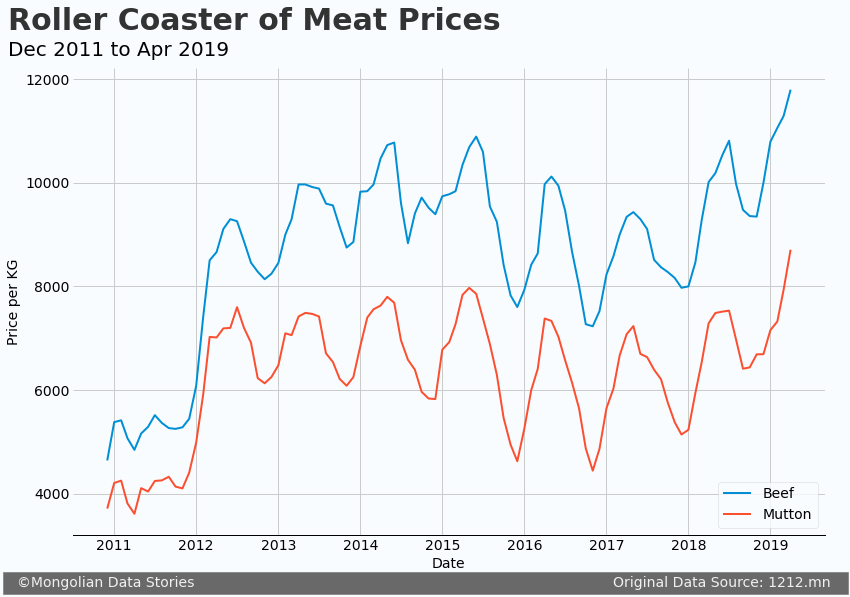

In [42]:
fig, ax = plt.subplots()
ax.plot(df['date'], df['Beef, without bones, kg'] , linewidth=2)
ax.plot(df['date'], df['Mutton, with bones, kg'],linewidth=2)
ax.set_xlabel('Date')
ax.set_ylabel('Price per KG')
ax.legend(['Beef','Mutton'],loc=4)

ax.text(x = 14500, y = 12950, s = 'Roller Coaster of Meat Prices', fontsize=30, weight='bold', alpha=.8)
ax.text(x = 14500, y = 12450, s= 'Dec 2011 to Apr 2019', fontsize=20)
ax.text(x = 14500, y = 2200, s = '  ©Mongolian Data Stories                                                                                             Original Data Source: 1212.mn   ', fontsize = 14, color = '#f0f0f0', backgroundcolor = 'dimgrey')
plt.savefig('Images/prices.png', dpi = 300, bbox_inches="tight")

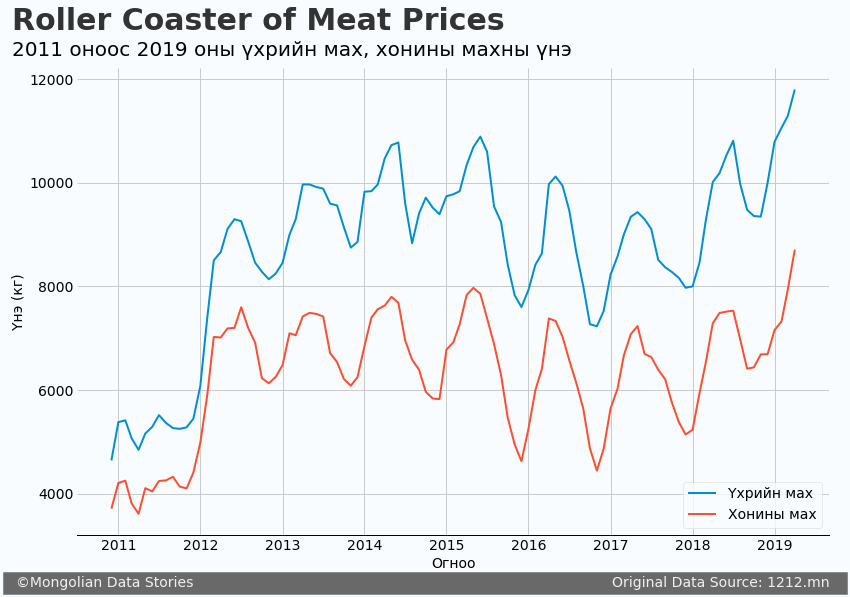

In [43]:
fig, ax = plt.subplots()
ax.plot(df['date'], df['Beef, without bones, kg'] , linewidth=2)
ax.plot(df['date'], df['Mutton, with bones, kg'],linewidth=2)
ax.set_xlabel('Огноо')
ax.set_ylabel('Үнэ (кг)')
ax.legend(['Үхрийн мах','Хонины мах'],loc=4)

ax.text(x = 14500, y = 12950, s = 'Roller Coaster of Meat Prices', fontsize=30, weight='bold', alpha=.8)
ax.text(x = 14500, y = 12450, s= '2011 оноос 2019 оны үхрийн мах, хонины махны үнэ', fontsize=20)
ax.text(x = 14480, y = 2200, s = '  ©Mongolian Data Stories                                                                                             Original Data Source: 1212.mn   ', fontsize = 14, color = '#f0f0f0', backgroundcolor = 'dimgrey')
plt.savefig('Images/prices-mng.png', dpi = 300, bbox_inches="tight")

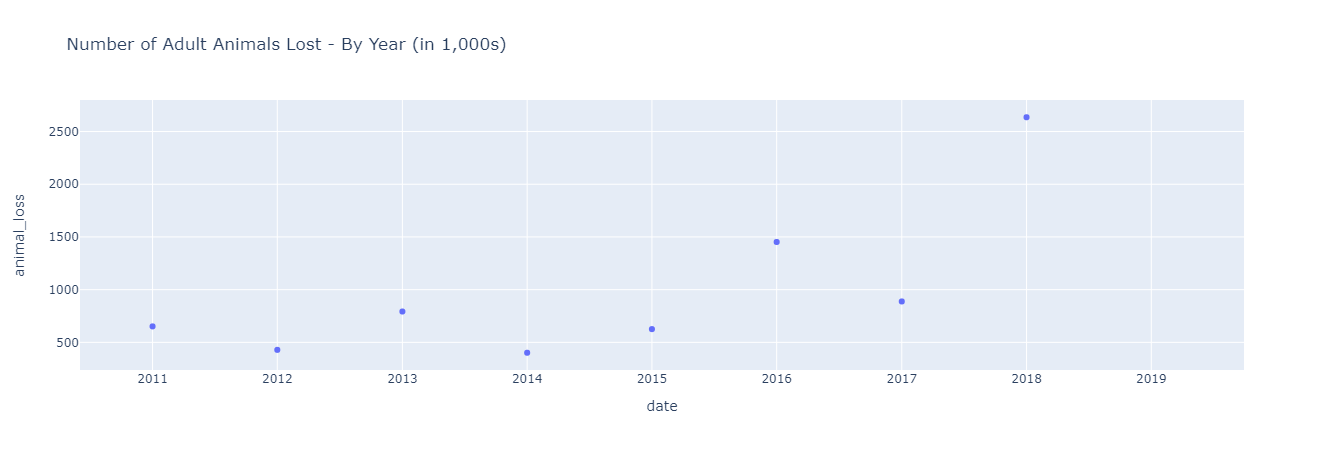

In [44]:
px.scatter(df, x='date', y='animal_loss', title='Number of Adult Animals Lost - By Year (in 1,000s)')

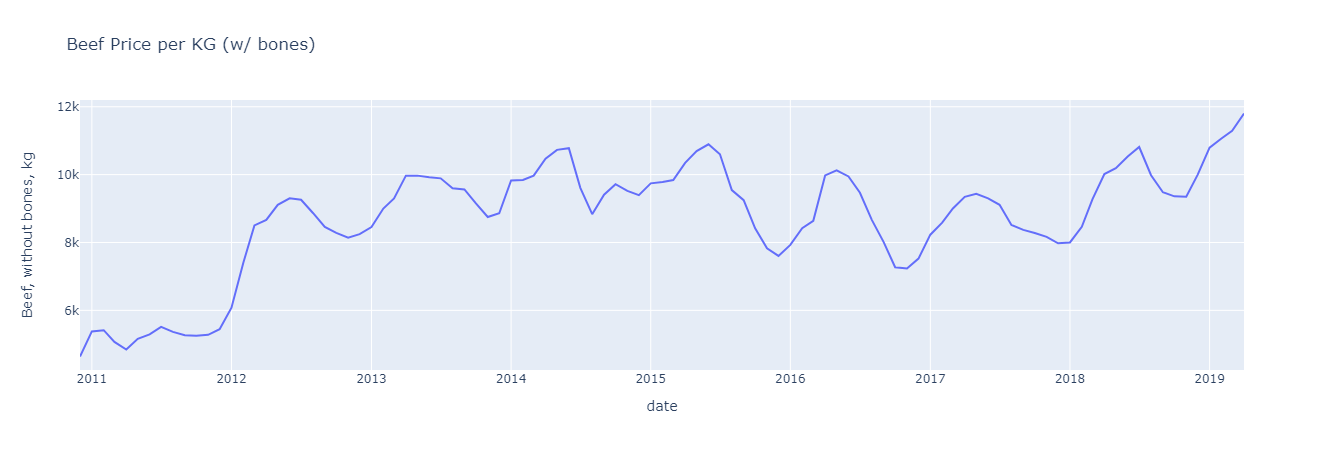

In [45]:
px.line(df, x='date', y='Beef, without bones, kg', title='Beef Price per KG (w/ bones)')

By looking at these two charts we can see that a higher livestock loss leads to a higher standard deviation for meat prices. 

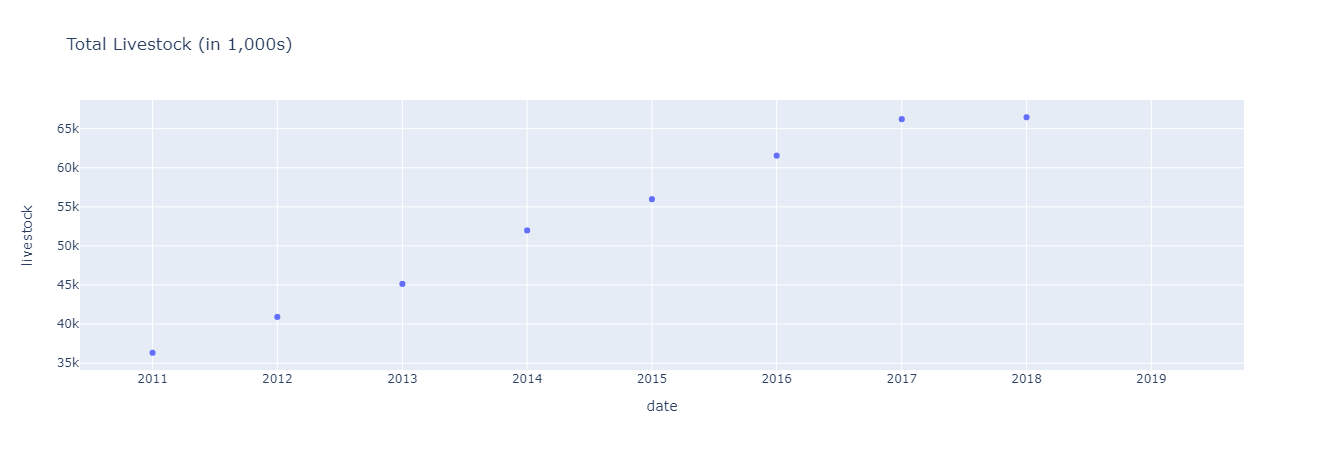

In [46]:
px.scatter(df, x='date', y='livestock', title='Total Livestock (in 1,000s)')

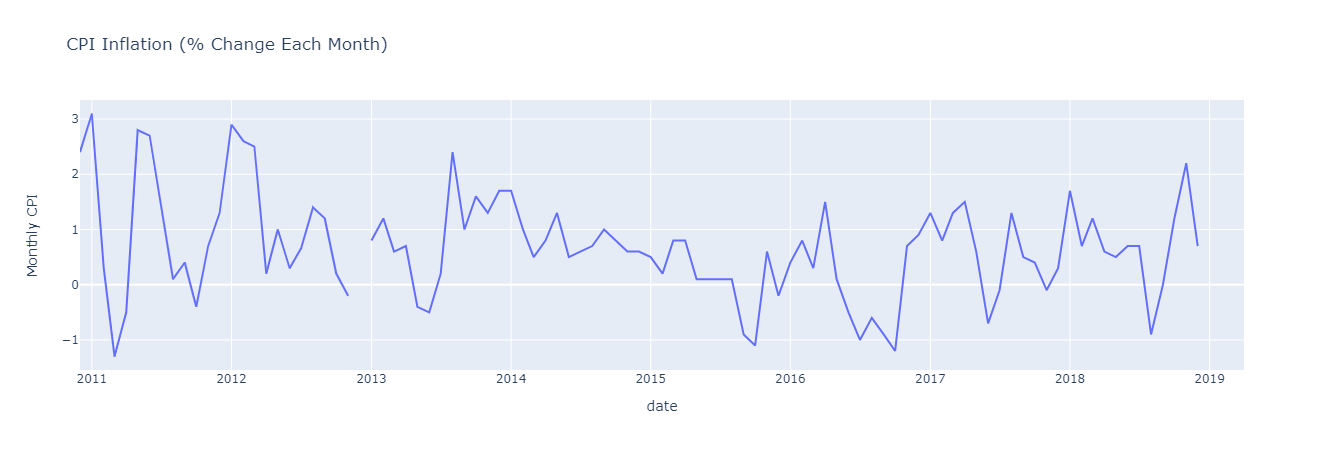

In [47]:
px.line(df, x='date', y='Monthly CPI', title='CPI Inflation (% Change Each Month)')

In [48]:
df.head()

date  Beef, without bones, kg  Mutton, with bones, kg  \
0 2010-12-01                     4640                    3710   
1 2011-01-01                     5380                    4205   
2 2011-02-01                     5415                    4250   
3 2011-03-01                     5070                    3810   
4 2011-04-01                     4845                    3610   

   Goat meat, with bones, kg  Chicken, thigh, kg, imported  \
0                     2590.0                        4420.0   
1                     3165.0                        4285.0   
2                     3395.0                        4195.0   
3                     3260.0                        4090.0   
4                     2805.0                        3910.0   

   Horse meat, with bones, kg  Frozen beef   (t)  Horse meat (t)  \
0                      2710.0                NaN             NaN   
1                      3460.0                NaN          3865.1   
2                      3605.0                NaN             NaN   
3                      3535.0                NaN             NaN   
4                      3290.0                NaN             NaN   

   Edible meet offal (t)  animal_loss  Monthly CPI  avg_salary  livestock  \
0                    NaN          NaN          2.4         NaN        NaN   
1                  414.6        651.3          3.1       430.3   36335.78   
2                    NaN          NaN          0.3         NaN        NaN   
3                    NaN          NaN         -1.3         NaN        NaN   
4                    NaN          NaN         -0.5       462.1        NaN   

   animal_product_export  Beef without bones adj  Mutton adj  
0                    NaN                     NaN         NaN  
1                39946.9                  5380.0      4205.0  
2                    NaN                  5396.0      4218.0  
3                    NaN                  5326.0      4163.0  
4                    NaN                  5299.0      4142.0

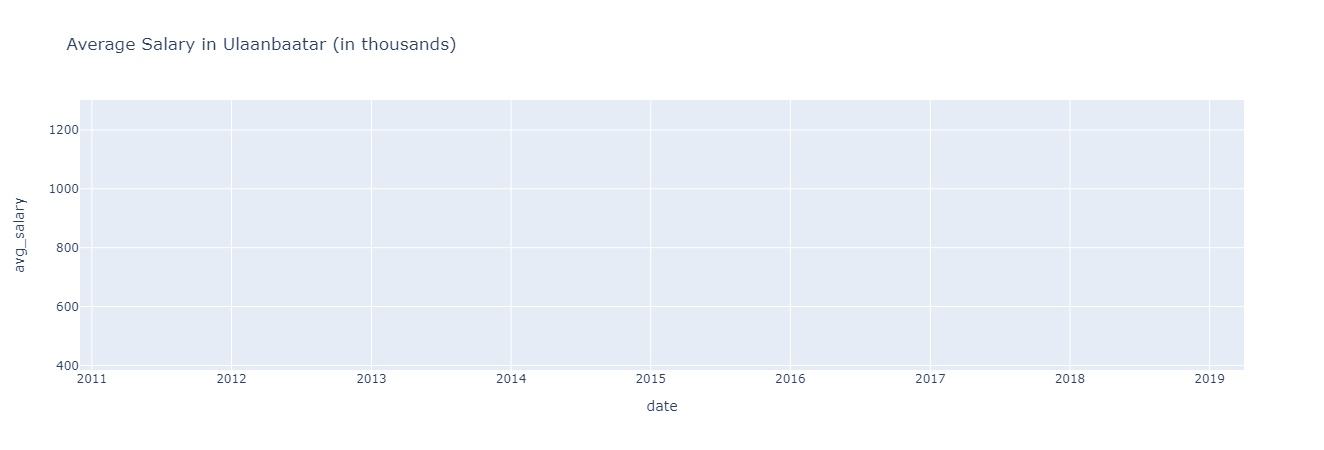

In [49]:
px.line(df, x='date', y='avg_salary', title='Average Salary in Ulaanbaatar (in thousands)')

It also appears that inflation has steadily gone up while meat prices have not followed this trend at all.

### Meat prices vs CPI

In [50]:
df.head()

date  Beef, without bones, kg  Mutton, with bones, kg  \
0 2010-12-01                     4640                    3710   
1 2011-01-01                     5380                    4205   
2 2011-02-01                     5415                    4250   
3 2011-03-01                     5070                    3810   
4 2011-04-01                     4845                    3610   

   Goat meat, with bones, kg  Chicken, thigh, kg, imported  \
0                     2590.0                        4420.0   
1                     3165.0                        4285.0   
2                     3395.0                        4195.0   
3                     3260.0                        4090.0   
4                     2805.0                        3910.0   

   Horse meat, with bones, kg  Frozen beef   (t)  Horse meat (t)  \
0                      2710.0                NaN             NaN   
1                      3460.0                NaN          3865.1   
2                      3605.0                NaN             NaN   
3                      3535.0                NaN             NaN   
4                      3290.0                NaN             NaN   

   Edible meet offal (t)  animal_loss  Monthly CPI  avg_salary  livestock  \
0                    NaN          NaN          2.4         NaN        NaN   
1                  414.6        651.3          3.1       430.3   36335.78   
2                    NaN          NaN          0.3         NaN        NaN   
3                    NaN          NaN         -1.3         NaN        NaN   
4                    NaN          NaN         -0.5       462.1        NaN   

   animal_product_export  Beef without bones adj  Mutton adj  
0                    NaN                     NaN         NaN  
1                39946.9                  5380.0      4205.0  
2                    NaN                  5396.0      4218.0  
3                    NaN                  5326.0      4163.0  
4                    NaN                  5299.0      4142.0

We can visualize the actual price of beef compared to what it would be if beef tracked with CPI. To do this we use our first price as the starting point. From there we adjust the meat price based on the the monthly inflation percentage using the formula below.

Prev price * (1 + Monthly Inflation %) = Adjusted price

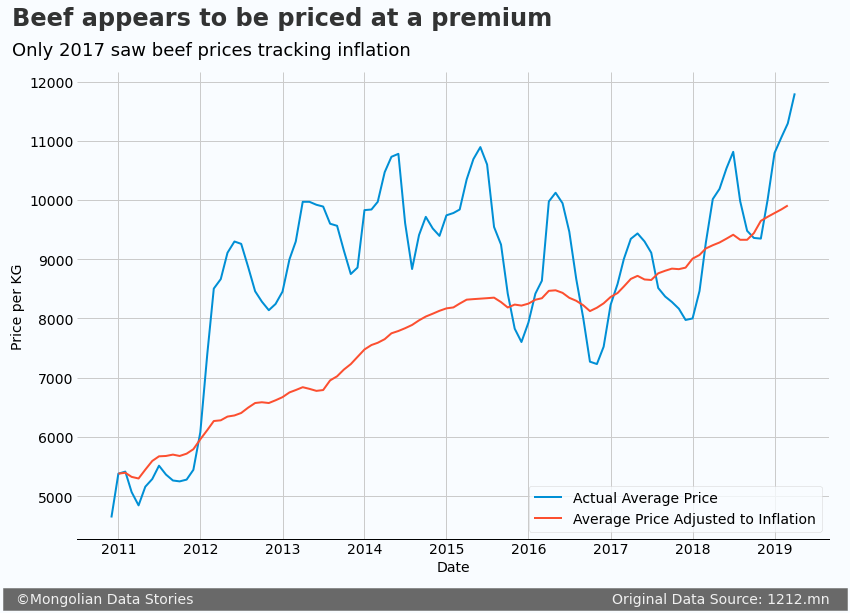

In [51]:
fig, ax = plt.subplots()
ax.plot(df['date'], df['Beef, without bones, kg'] , linewidth=2)
ax.plot(df['date'], df['Beef without bones adj'],linewidth=2)
ax.set_xlabel('Date')
ax.set_ylabel('Price per KG')
ax.legend(['Actual Average Price','Average Price Adjusted to Inflation'],loc=4)

ax.text(x = 14500, y = 12950, s = 'Beef appears to be priced at a premium', fontsize=24, weight='bold', alpha=.8)
ax.text(x = 14500, y = 12450, s= 'Only 2017 saw beef prices tracking inflation', fontsize=18)
ax.text(x = 14480, y = 3200, s = '  ©Mongolian Data Stories                                                                                             Original Data Source: 1212.mn   ', fontsize = 14, color = '#f0f0f0', backgroundcolor = 'dimgrey')
plt.savefig('Images/beef-inflation.png', dpi = 300, bbox_inches="tight")

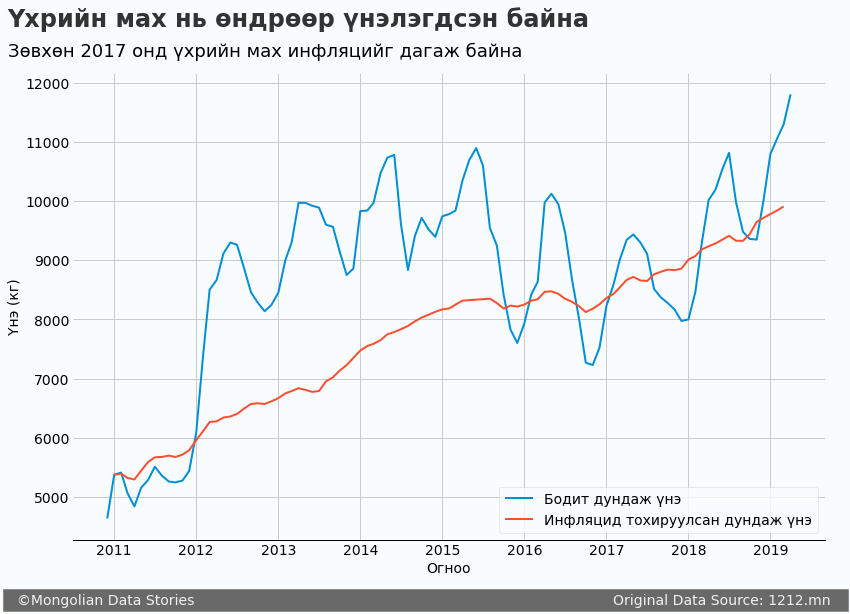

In [52]:
fig, ax = plt.subplots()
ax.plot(df['date'], df['Beef, without bones, kg'] , linewidth=2)
ax.plot(df['date'], df['Beef without bones adj'],linewidth=2)
ax.set_xlabel('Огноо')
ax.set_ylabel('Үнэ (кг)')
ax.legend(['Бодит дундаж үнэ','Инфляцид тохируулсан дундаж үнэ'],loc=4)

ax.text(x = 14500, y = 12950, s = 'Үхрийн мах нь өндрөөр үнэлэгдсэн байна', fontsize=24, weight='bold', alpha=.8)
ax.text(x = 14500, y = 12450, s= 'Зөвхөн 2017 онд үхрийн мах инфляцийг дагаж байна', fontsize=18)
ax.text(x = 14500, y = 3200, s = '  ©Mongolian Data Stories                                                                                             Original Data Source: 1212.mn   ', fontsize = 14, color = '#f0f0f0', backgroundcolor = 'dimgrey')
plt.savefig('Images/beef-inflation-mng.png', dpi = 300, bbox_inches="tight")

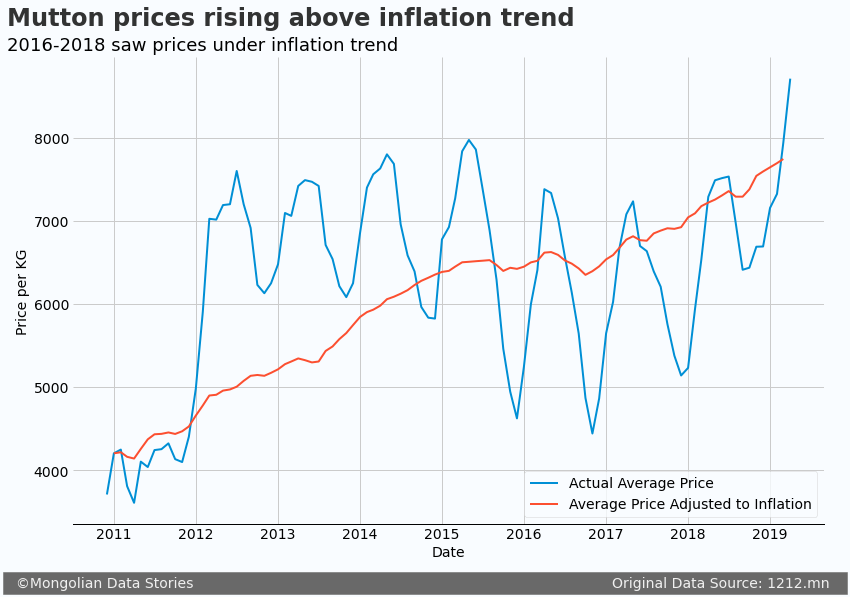

In [53]:
fig, ax = plt.subplots()
ax.plot(df['date'], df['Mutton, with bones, kg'] , linewidth=2)
ax.plot(df['date'], df['Mutton adj'],linewidth=2)
ax.set_xlabel('Date')
ax.set_ylabel('Price per KG')
ax.legend(['Actual Average Price','Average Price Adjusted to Inflation'],loc=4)

ax.text(x = 14500, y = 9350, s = 'Mutton prices rising above inflation trend', fontsize=24, weight='bold', alpha=.8)
ax.text(x = 14500, y = 9050, s= '2016-2018 saw prices under inflation trend', fontsize=18)
ax.text(x = 14500, y = 2600, s = '  ©Mongolian Data Stories                                                                                             Original Data Source: 1212.mn   ', fontsize = 14, color = '#f0f0f0', backgroundcolor = 'dimgrey')
plt.savefig('Images/mutton-inflation.png', dpi = 300, bbox_inches="tight")

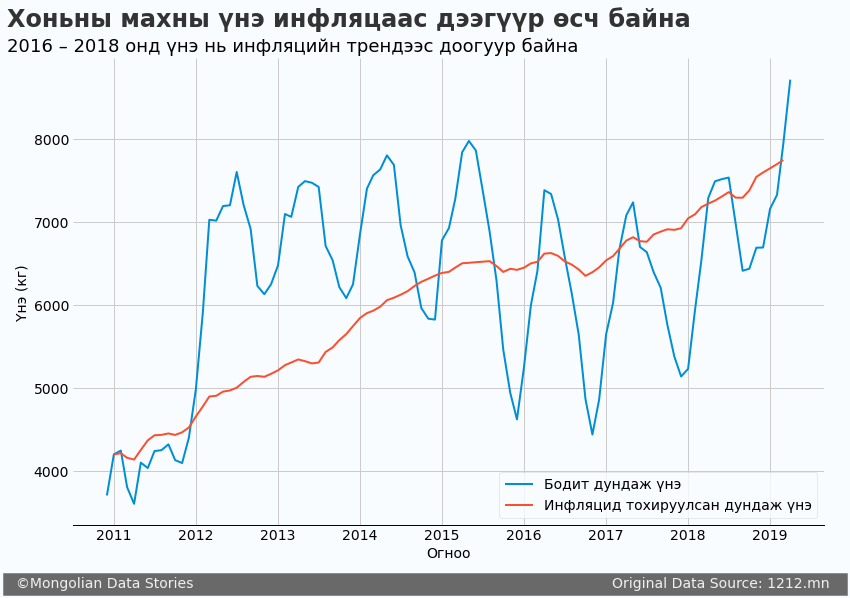

In [54]:
fig, ax = plt.subplots()
ax.plot(df['date'], df['Mutton, with bones, kg'] , linewidth=2)
ax.plot(df['date'], df['Mutton adj'],linewidth=2)
ax.set_xlabel('Огноо')
ax.set_ylabel('Үнэ (кг)')
ax.legend(['Бодит дундаж үнэ','Инфляцид тохируулсан дундаж үнэ'],loc=4)

ax.text(x = 14500, y = 9350, s = 'Хоньны махны үнэ инфляцаас дээгүүр өсч байна', fontsize=24, weight='bold', alpha=.8)
ax.text(x = 14500, y = 9050, s= '2016 – 2018 онд үнэ нь инфляцийн трендээс доогуур байна', fontsize=18)
ax.text(x = 14500, y = 2600, s = '  ©Mongolian Data Stories                                                                                             Original Data Source: 1212.mn   ', fontsize = 14, color = '#f0f0f0', backgroundcolor = 'dimgrey')
plt.savefig('Images/mutton-inflation-mng.png', dpi = 300, bbox_inches="tight")

For both beef and mutton prices from 2012-2015 were above the adjusted line. Mutton trended below the adjusted line from 2016-2019. Beef however appears to track the adjusted line for 2016 and 2017. For 2018 and now 2019 beef prices are above the line. 

### Animal loss and prices

In [55]:
df.head()

date  Beef, without bones, kg  Mutton, with bones, kg  \
0 2010-12-01                     4640                    3710   
1 2011-01-01                     5380                    4205   
2 2011-02-01                     5415                    4250   
3 2011-03-01                     5070                    3810   
4 2011-04-01                     4845                    3610   

   Goat meat, with bones, kg  Chicken, thigh, kg, imported  \
0                     2590.0                        4420.0   
1                     3165.0                        4285.0   
2                     3395.0                        4195.0   
3                     3260.0                        4090.0   
4                     2805.0                        3910.0   

   Horse meat, with bones, kg  Frozen beef   (t)  Horse meat (t)  \
0                      2710.0                NaN             NaN   
1                      3460.0                NaN          3865.1   
2                      3605.0                NaN             NaN   
3                      3535.0                NaN             NaN   
4                      3290.0                NaN             NaN   

   Edible meet offal (t)  animal_loss  Monthly CPI  avg_salary  livestock  \
0                    NaN          NaN          2.4         NaN        NaN   
1                  414.6        651.3          3.1       430.3   36335.78   
2                    NaN          NaN          0.3         NaN        NaN   
3                    NaN          NaN         -1.3         NaN        NaN   
4                    NaN          NaN         -0.5       462.1        NaN   

   animal_product_export  Beef without bones adj  Mutton adj  
0                    NaN                     NaN         NaN  
1                39946.9                  5380.0      4205.0  
2                    NaN                  5396.0      4218.0  
3                    NaN                  5326.0      4163.0  
4                    NaN                  5299.0      4142.0

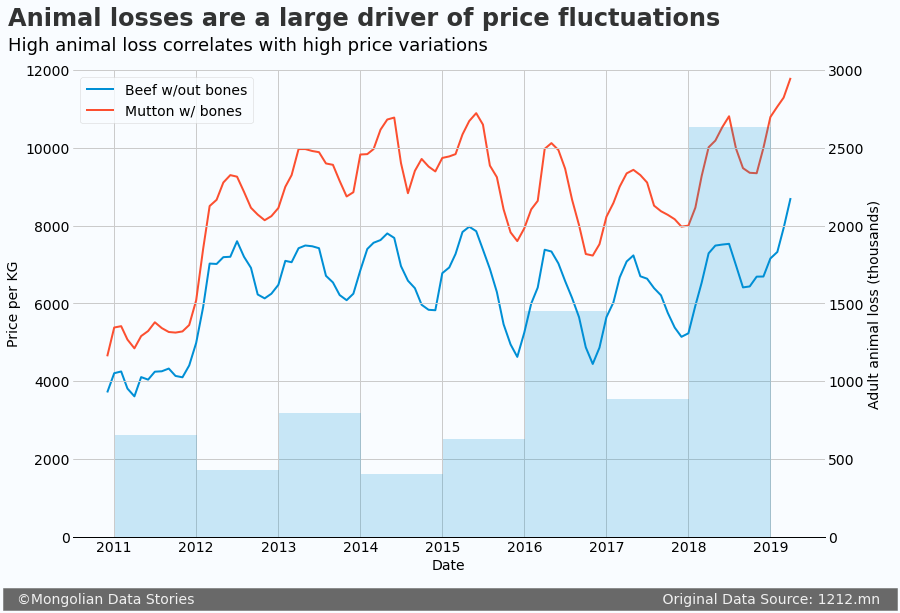

In [56]:
from datetime import timedelta 

fig, ax = plt.subplots()
ax.plot(df['date'], df['Mutton, with bones, kg'] , linewidth=2)
ax.plot(df['date'], df['Beef, without bones, kg'] , linewidth=2)
ax2 = ax.twinx()
ax2.bar(df['date']  + timedelta(days=185), df['animal_loss'],width=365,alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Price per KG')
ax2.set_ylabel('Adult animal loss (thousands)')
ax.legend(['Beef w/out bones','Mutton w/ bones'],loc=2)
ax.set_ylim(0,12000)
ax2.set_yticks(np.linspace(ax2.get_yticks()[0], ax2.get_yticks()[-1], len(ax.get_yticks())))


ax.text(x = 14500, y = 13150, s = 'Animal losses are a large driver of price fluctuations', fontsize=24, weight='bold', alpha=.8)
ax.text(x = 14500, y = 12500, s= 'High animal loss correlates with high price variations', fontsize=18)
ax.text(x = 14500, y = -1700, s = '  ©Mongolian Data Stories                                                                                                        Original Data Source: 1212.mn   ', fontsize = 14, color = '#f0f0f0', backgroundcolor = 'dimgrey')
plt.savefig('Images/losses.png', dpi = 300, bbox_inches="tight")

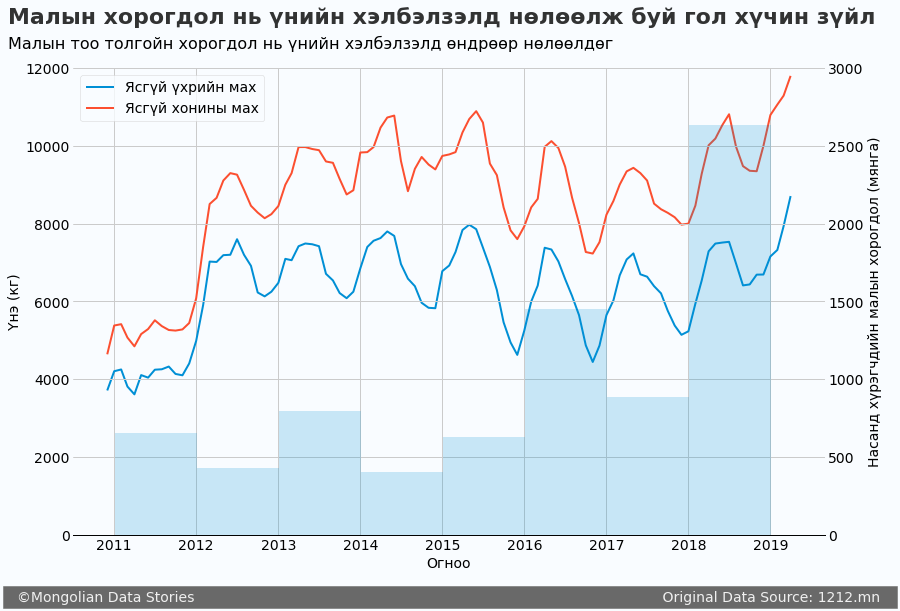

In [57]:
from datetime import timedelta 

fig, ax = plt.subplots()
ax.plot(df['date'], df['Mutton, with bones, kg'] , linewidth=2)
ax.plot(df['date'], df['Beef, without bones, kg'] , linewidth=2)
ax2 = ax.twinx()
ax2.bar(df['date']  + timedelta(days=185), df['animal_loss'],width=365,alpha=.2)
ax.set_xlabel('Огноо')
ax.set_ylabel('Үнэ (кг)')
ax2.set_ylabel('Насанд хүрэгчдийн малын хорогдол (мянга)')
ax.legend(['Ясгүй үхрийн мах','Ясгүй хонины мах'],loc=2)
ax.set_ylim(0,12000)
ax2.set_yticks(np.linspace(ax2.get_yticks()[0], ax2.get_yticks()[-1], len(ax.get_yticks())))


ax.text(x = 14500, y = 13150, s = 'Малын хорогдол нь үнийн хэлбэлзэлд нөлөөлж буй гол хүчин зүйл', fontsize=22, weight='bold', alpha=.8)
ax.text(x = 14500, y = 12500, s= 'Малын тоо толгойн хорогдол нь үнийн хэлбэлзэлд өндрөөр нөлөөлдөг', fontsize=16)
ax.text(x = 14500, y = -1700, s = '  ©Mongolian Data Stories                                                                                                        Original Data Source: 1212.mn   ', fontsize = 14, color = '#f0f0f0', backgroundcolor = 'dimgrey')
plt.savefig('Images/losses-mng.png', dpi = 300, bbox_inches="tight")

### Exports and meat prices

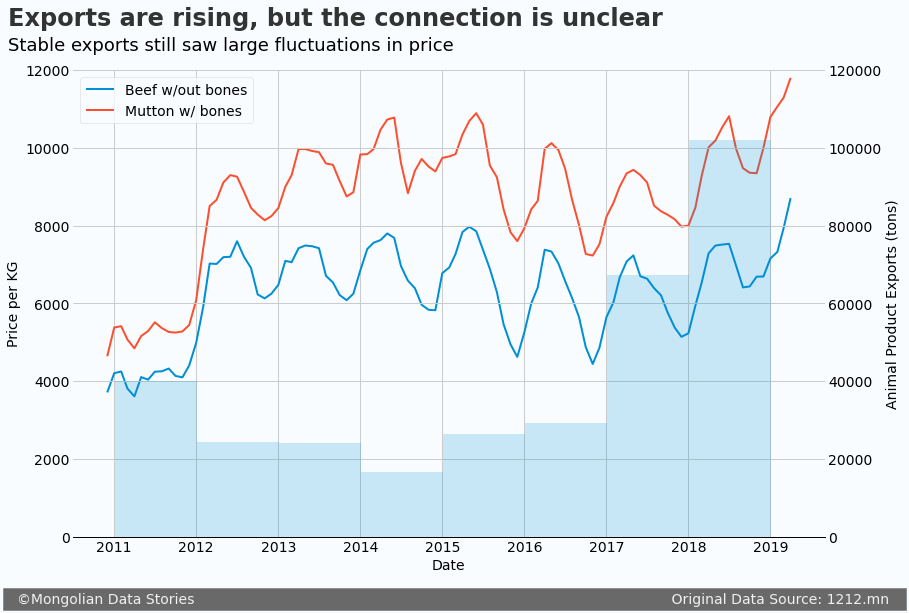

In [58]:
from datetime import timedelta

fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(df['date'], df['Mutton, with bones, kg'] , linewidth=2)
ax.plot(df['date'], df['Beef, without bones, kg'] , linewidth=2)
ax2.bar(df['date']  + timedelta(days=185), df['animal_product_export'],width=365,alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Price per KG')
ax2.set_ylabel('Animal Product Exports (tons)')
ax.legend(['Beef w/out bones','Mutton w/ bones'],loc=2)
ax.set_ylim(0,12000)
ax2.set_yticks(np.linspace(ax2.get_yticks()[0], ax2.get_yticks()[-1], len(ax.get_yticks())))

ax.text(x = 14500, y = 13150, s = 'Exports are rising, but the connection is unclear', fontsize=24, weight='bold', alpha=.8)
ax.text(x = 14500, y = 12500, s= 'Stable exports still saw large fluctuations in price', fontsize=18)
ax.text(x = 14500, y = -1700, s = '  ©Mongolian Data Stories                                                                                                          Original Data Source: 1212.mn   ', fontsize = 14, color = '#f0f0f0', backgroundcolor = 'dimgrey')
plt.savefig('Images/exports.png', dpi = 300, bbox_inches="tight")

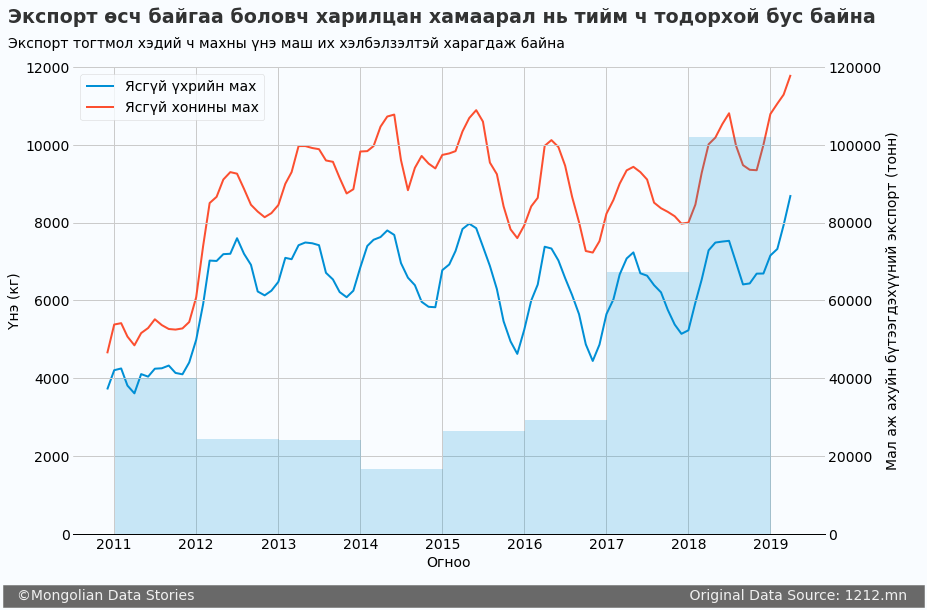

In [59]:
from datetime import timedelta

fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(df['date'], df['Mutton, with bones, kg'] , linewidth=2)
ax.plot(df['date'], df['Beef, without bones, kg'] , linewidth=2)
ax2.bar(df['date']  + timedelta(days=185), df['animal_product_export'],width=365,alpha=.2)
ax.set_xlabel('Огноо')
ax.set_ylabel('Үнэ (кг)')
ax2.set_ylabel('Мал аж ахуйн бүтээгдэхүүний экспорт (тонн)')
ax.legend(['Ясгүй үхрийн мах','Ясгүй хонины мах'],loc=2)
ax.set_ylim(0,12000)
ax2.set_yticks(np.linspace(ax2.get_yticks()[0], ax2.get_yticks()[-1], len(ax.get_yticks())))

ax.text(x = 14500, y = 13150, s = 'Экспорт өсч байгаа боловч харилцан хамаарал нь тийм ч тодорхой бус байна', fontsize=19, weight='bold', alpha=.8)
ax.text(x = 14500, y = 12500, s= 'Экспорт тогтмол хэдий ч махны үнэ маш их хэлбэлзэлтэй харагдаж байна', fontsize=14)
ax.text(x = 14500, y = -1700, s = '  ©Mongolian Data Stories                                                                                                              Original Data Source: 1212.mn   ', fontsize = 14, color = '#f0f0f0', backgroundcolor = 'dimgrey')
plt.savefig('Images/exports-mng.png', dpi = 300, bbox_inches="tight")

### Meat prices vs average salary

In [60]:
df.head()

date  Beef, without bones, kg  Mutton, with bones, kg  \
0 2010-12-01                     4640                    3710   
1 2011-01-01                     5380                    4205   
2 2011-02-01                     5415                    4250   
3 2011-03-01                     5070                    3810   
4 2011-04-01                     4845                    3610   

   Goat meat, with bones, kg  Chicken, thigh, kg, imported  \
0                     2590.0                        4420.0   
1                     3165.0                        4285.0   
2                     3395.0                        4195.0   
3                     3260.0                        4090.0   
4                     2805.0                        3910.0   

   Horse meat, with bones, kg  Frozen beef   (t)  Horse meat (t)  \
0                      2710.0                NaN             NaN   
1                      3460.0                NaN          3865.1   
2                      3605.0                NaN             NaN   
3                      3535.0                NaN             NaN   
4                      3290.0                NaN             NaN   

   Edible meet offal (t)  animal_loss  Monthly CPI  avg_salary  livestock  \
0                    NaN          NaN          2.4         NaN        NaN   
1                  414.6        651.3          3.1       430.3   36335.78   
2                    NaN          NaN          0.3         NaN        NaN   
3                    NaN          NaN         -1.3         NaN        NaN   
4                    NaN          NaN         -0.5       462.1        NaN   

   animal_product_export  Beef without bones adj  Mutton adj  
0                    NaN                     NaN         NaN  
1                39946.9                  5380.0      4205.0  
2                    NaN                  5396.0      4218.0  
3                    NaN                  5326.0      4163.0  
4                    NaN                  5299.0      4142.0

It is clear now that meat prices are going up, and seem to be trending above inflation. We also have salary data for Ulaanbaatar. What we can do is see what percent of an average salary a set amount of consumption of meat is. 

We will use a set consumption of 750g per day (equivalent to the American average for three people in 2018).

In [61]:
# calculate the meat prices as percentage
df['avg_salary'] = df['avg_salary'].fillna(method='ffill')
df['beef_salary_percent'] = ((df['Beef, without bones, kg']/1000)*750*30)/(df['avg_salary']*1000)*100
df['mutton_salary_percent'] = ((df['Mutton, with bones, kg']/1000)*750*30)/(df['avg_salary']*1000)*100

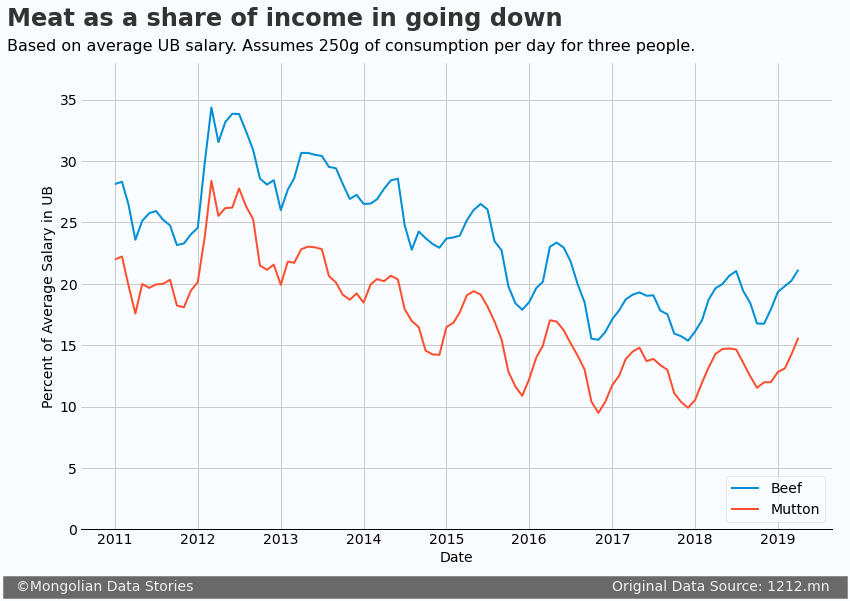

In [62]:
fig, ax = plt.subplots()
ax.plot(df['date'], df['beef_salary_percent'] , linewidth=2)
ax.plot(df['date'], df['mutton_salary_percent'],linewidth=2)
ax.set_xlabel('Date')
ax.set_ylabel('Percent of Average Salary in UB')
ax.legend(['Beef','Mutton'],loc=4)
ax.set_ylim(0,38)

ax.text(x = 14500, y = 41, s = 'Meat as a share of income in going down', fontsize=24, weight='bold', alpha=.8)
ax.text(x = 14500, y = 39, s= 'Based on average UB salary. Assumes 250g of consumption per day for three people.', fontsize=16)
ax.text(x = 14500, y = -5, s = '  ©Mongolian Data Stories                                                                                             Original Data Source: 1212.mn   ', fontsize = 14, color = '#f0f0f0', backgroundcolor = 'dimgrey')
plt.savefig('Images/salary.png', dpi = 300, bbox_inches="tight")

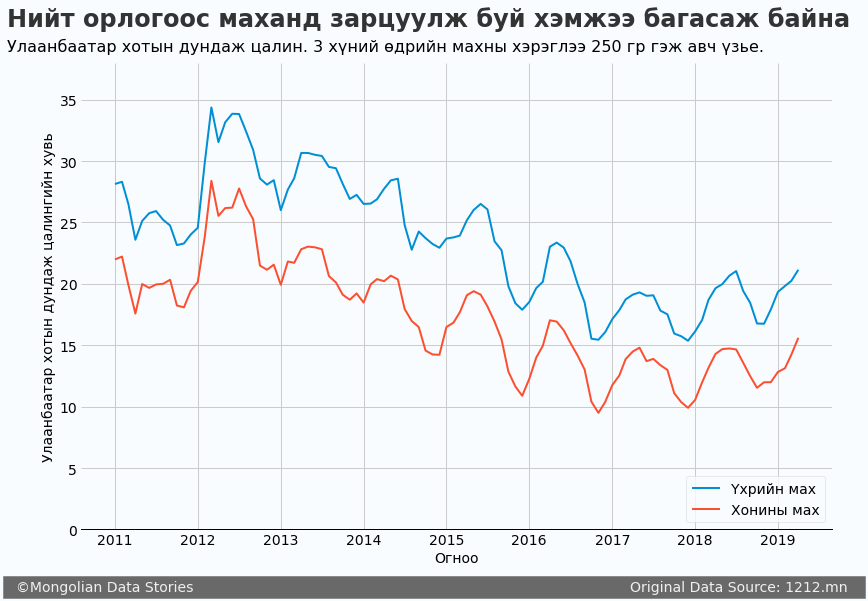

In [63]:
fig, ax = plt.subplots()
ax.plot(df['date'], df['beef_salary_percent'] , linewidth=2)
ax.plot(df['date'], df['mutton_salary_percent'],linewidth=2)
ax.set_xlabel('Огноо')
ax.set_ylabel('Улаанбаатар хотын дундаж цалингийн хувь')
ax.legend(['Үхрийн мах','Хонины мах'],loc=4)
ax.set_ylim(0,38)

ax.text(x = 14500, y = 41, s = 'Нийт орлогоос маханд зарцуулж буй хэмжээ багасаж байна', fontsize=24, weight='bold', alpha=.8)
ax.text(x = 14500, y = 39, s= 'Улаанбаатар хотын дундаж цалин. 3 хүний өдрийн махны хэрэглээ 250 гр гэж авч үзье.', fontsize=16)
ax.text(x = 14500, y = -5, s = '  ©Mongolian Data Stories                                                                                                 Original Data Source: 1212.mn   ', fontsize = 14, color = '#f0f0f0', backgroundcolor = 'dimgrey')
plt.savefig('Images/salary-mng.png', dpi = 300, bbox_inches="tight")

### Average Price of Other Domestic Items

Let's take a look at the average price of other domestic items. Below we will create an index chart to show the proportion prices have changed. 

In [64]:
df2 = pd.read_csv('Data/intermediate/price of commodities.csv')

In [65]:
df2.head()

Date  Restaurant food /capital salad, gulyas, tea/  \
0  12/1/2010                                          5500   
1   1/1/2011                                          5550   
2   2/1/2011                                          5550   
3   3/1/2011                                          5550   
4   4/1/2011                                          5550   

   Canteen food, /tsuivan, milk tea/  Mens haircuts  \
0                             2700.0           2500   
1                             2700.0           2500   
2                             2700.0           2500   
3                             2700.0           2500   
4                             2700.0           2500   

   Womens haircuts, simple cuts  
0                          2920  
1                          3000  
2                          3000  
3                          3000  
4                          3050

In [66]:
df2['date'] = pd.to_datetime(df2['Date'])

Let's calculate a market index of these commodities and meat prices using 12/2010 as 100.

In [67]:
df2['restaurant_gulyash_index'] = df2['Restaurant food /capital salad, gulyas, tea/'] / df2['Restaurant food /capital salad, gulyas, tea/'][0] *100
df2['tsuivan_index'] = df2['Canteen food, /tsuivan, milk tea/'] / df2['Canteen food, /tsuivan, milk tea/'][0] *100
df2['men_haircut_index'] = df2['Mens haircuts'] / df2['Mens haircuts'][0] *100
df2['women_haircut_index'] = df2['Womens haircuts, simple cuts'] / df2['Womens haircuts, simple cuts'][0] *100

df2['beef_index'] = df['Beef, without bones, kg'] / df['Beef, without bones, kg'][0] *100
df2['mutton_index'] = df['Mutton, with bones, kg'] / df['Mutton, with bones, kg'][0] *100

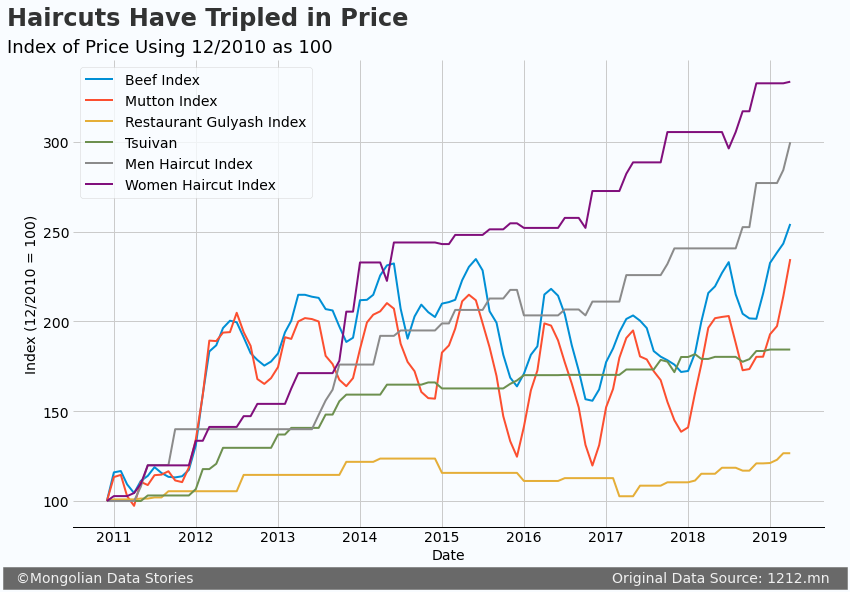

In [68]:
fig, ax = plt.subplots()
ax.plot(df2['date'], df2['beef_index'] , linewidth=2)
ax.plot(df2['date'], df2['mutton_index'],linewidth=2)
ax.plot(df2['date'], df2['restaurant_gulyash_index'],linewidth=2)
ax.plot(df2['date'], df2['tsuivan_index'],linewidth=2)
ax.plot(df2['date'], df2['men_haircut_index'],linewidth=2)
ax.plot(df2['date'], df2['women_haircut_index'],linewidth=2)

ax.set_xlabel('Date')
ax.set_ylabel('Index (12/2010 = 100)')
ax.legend(['Beef Index','Mutton Index','Restaurant Gulyash Index','Tsuivan','Men Haircut Index','Women Haircut Index'],loc=2)

ax.text(x = 14500, y = 365, s = 'Haircuts Have Tripled in Price', fontsize=24, weight='bold', alpha=.8)
ax.text(x = 14500, y = 350, s= 'Index of Price Using 12/2010 as 100', fontsize=18)
ax.text(x = 14500, y = 55, s = '  ©Mongolian Data Stories                                                                                             Original Data Source: 1212.mn   ', fontsize = 14, color = '#f0f0f0', backgroundcolor = 'dimgrey')
plt.savefig('Images/price_index.png', dpi = 300, bbox_inches="tight")

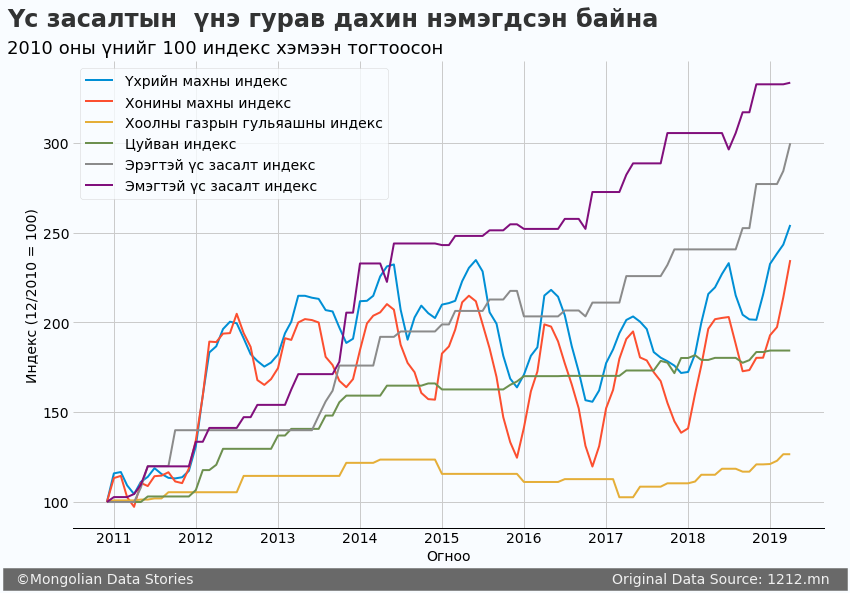

In [69]:
fig, ax = plt.subplots()
ax.plot(df2['date'], df2['beef_index'] , linewidth=2)
ax.plot(df2['date'], df2['mutton_index'],linewidth=2)
ax.plot(df2['date'], df2['restaurant_gulyash_index'],linewidth=2)
ax.plot(df2['date'], df2['tsuivan_index'],linewidth=2)
ax.plot(df2['date'], df2['men_haircut_index'],linewidth=2)
ax.plot(df2['date'], df2['women_haircut_index'],linewidth=2)

ax.set_xlabel('Огноо')
ax.set_ylabel('Индекс (12/2010 = 100)')
ax.legend(['Үхрийн махны индекс','Хонины махны индекс','Хоолны газрын гульяашны индекс','Цуйван индекс','Эрэгтэй үс засалт индекс','Эмэгтэй үс засалт индекс'],loc=2)

ax.text(x = 14500, y = 365, s = 'Үс засалтын  үнэ гурав дахин нэмэгдсэн байна', fontsize=24, weight='bold', alpha=.8)
ax.text(x = 14500, y = 350, s= '2010 оны үнийг 100 индекс хэмээн тогтоосон', fontsize=18)
ax.text(x = 14500, y = 55, s = '  ©Mongolian Data Stories                                                                                             Original Data Source: 1212.mn   ', fontsize = 14, color = '#f0f0f0', backgroundcolor = 'dimgrey')
plt.savefig('Images/price_index-mng.png', dpi = 300, bbox_inches="tight")

## Forecast with Prophet

While a machine learning model may work, the seasonality and relatively small amount of data show that it may be a good idea to use Prophet to make forecasts.

In [70]:
from fbprophet import Prophet

In [71]:
df.head()

date  Beef, without bones, kg  Mutton, with bones, kg  \
0 2010-12-01                     4640                    3710   
1 2011-01-01                     5380                    4205   
2 2011-02-01                     5415                    4250   
3 2011-03-01                     5070                    3810   
4 2011-04-01                     4845                    3610   

   Goat meat, with bones, kg  Chicken, thigh, kg, imported  \
0                     2590.0                        4420.0   
1                     3165.0                        4285.0   
2                     3395.0                        4195.0   
3                     3260.0                        4090.0   
4                     2805.0                        3910.0   

   Horse meat, with bones, kg  Frozen beef   (t)  Horse meat (t)  \
0                      2710.0                NaN             NaN   
1                      3460.0                NaN          3865.1   
2                      3605.0                NaN             NaN   
3                      3535.0                NaN             NaN   
4                      3290.0                NaN             NaN   

   Edible meet offal (t)  animal_loss  Monthly CPI  avg_salary  livestock  \
0                    NaN          NaN          2.4         NaN        NaN   
1                  414.6        651.3          3.1       430.3   36335.78   
2                    NaN          NaN          0.3       430.3        NaN   
3                    NaN          NaN         -1.3       430.3        NaN   
4                    NaN          NaN         -0.5       462.1        NaN   

   animal_product_export  Beef without bones adj  Mutton adj  \
0                    NaN                     NaN         NaN   
1                39946.9                  5380.0      4205.0   
2                    NaN                  5396.0      4218.0   
3                    NaN                  5326.0      4163.0   
4                    NaN                  5299.0      4142.0   

   beef_salary_percent  mutton_salary_percent  
0                  NaN                    NaN  
1            28.131536              21.987567  
2            28.314548              22.222868  
3            26.510574              19.922147  
4            23.590673              17.577364

### Beef Forecast

In [72]:
beef = pd.DataFrame(data=df.date,columns=['ds'])
beef['ds'] = df['date']
beef['y'] = df['Beef, without bones, kg']

In [73]:
beef['animal_loss'] = df['animal_loss'].fillna(method='ffill')

In [74]:
beef['animal_loss'] = beef['animal_loss'].fillna(method='bfill')

In [75]:
beef.head()

ds     y  animal_loss
0 2010-12-01  4640        651.3
1 2011-01-01  5380        651.3
2 2011-02-01  5415        651.3
3 2011-03-01  5070        651.3
4 2011-04-01  4845        651.3

In [76]:
b = Prophet(n_changepoints=12,changepoint_prior_scale=0.05)
b.add_regressor('animal_loss')
b.fit(beef)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [77]:
b_future = b.make_future_dataframe(periods=12, freq='M')
b_future['animal_loss'] = beef['animal_loss']
b_future.head()

ds  animal_loss
0 2010-12-01        651.3
1 2011-01-01        651.3
2 2011-02-01        651.3
3 2011-03-01        651.3
4 2011-04-01        651.3

In [78]:
np.mean(b_future['animal_loss'], axis=0)

1046.4984158415841

In [79]:
b_future['animal_loss'].fillna(value=np.mean(b_future['animal_loss'], axis=0),inplace=True)

In [80]:
b_forecast = b.predict(b_future)
b_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds          yhat    yhat_lower    yhat_upper
108 2019-11-30  10517.089462   9881.118541  11209.361387
109 2019-12-31  11365.875738  10686.763407  12117.463911
110 2020-01-31  12576.597801  11894.521318  13337.953901
111 2020-02-29  12354.406500  11631.364265  13192.625577
112 2020-03-31  12690.625649  12004.221383  13474.121343

In [81]:
b_forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'animal_loss', 'animal_loss_lower', 'animal_loss_upper',
       'extra_regressors_additive', 'extra_regressors_additive_lower',
       'extra_regressors_additive_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')

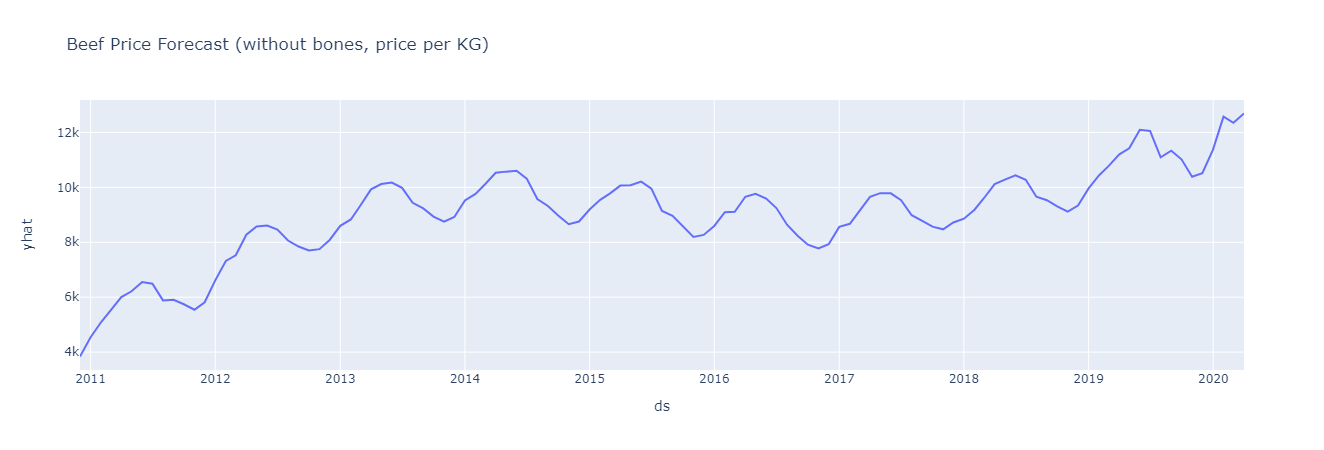

In [82]:
px.line(b_forecast, x='ds', y='yhat', title='Beef Price Forecast (without bones, price per KG)')

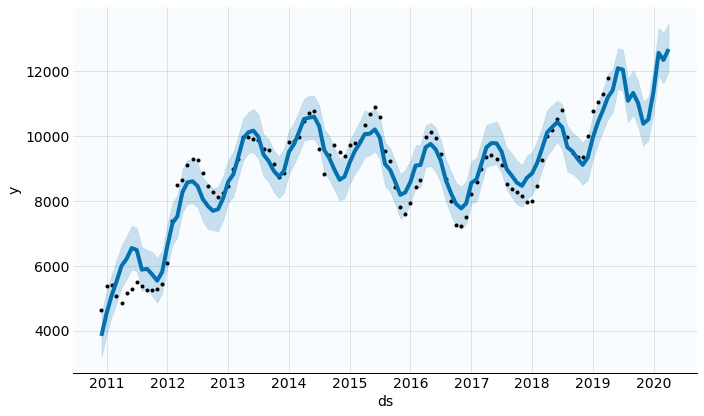

In [83]:
beef_forecast = b.plot(b_forecast)

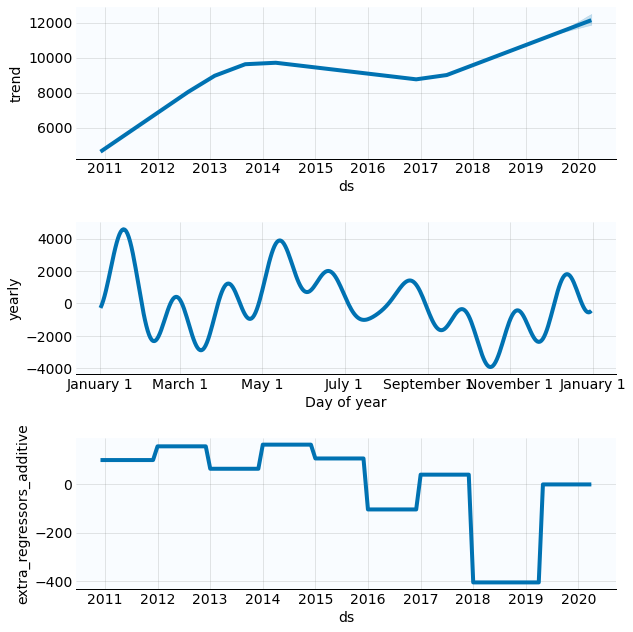

In [84]:
beef_components = b.plot_components(b_forecast)

### Mutton Forecast

In [85]:
df.head()

date  Beef, without bones, kg  Mutton, with bones, kg  \
0 2010-12-01                     4640                    3710   
1 2011-01-01                     5380                    4205   
2 2011-02-01                     5415                    4250   
3 2011-03-01                     5070                    3810   
4 2011-04-01                     4845                    3610   

   Goat meat, with bones, kg  Chicken, thigh, kg, imported  \
0                     2590.0                        4420.0   
1                     3165.0                        4285.0   
2                     3395.0                        4195.0   
3                     3260.0                        4090.0   
4                     2805.0                        3910.0   

   Horse meat, with bones, kg  Frozen beef   (t)  Horse meat (t)  \
0                      2710.0                NaN             NaN   
1                      3460.0                NaN          3865.1   
2                      3605.0                NaN             NaN   
3                      3535.0                NaN             NaN   
4                      3290.0                NaN             NaN   

   Edible meet offal (t)  animal_loss  Monthly CPI  avg_salary  livestock  \
0                    NaN          NaN          2.4         NaN        NaN   
1                  414.6        651.3          3.1       430.3   36335.78   
2                    NaN          NaN          0.3       430.3        NaN   
3                    NaN          NaN         -1.3       430.3        NaN   
4                    NaN          NaN         -0.5       462.1        NaN   

   animal_product_export  Beef without bones adj  Mutton adj  \
0                    NaN                     NaN         NaN   
1                39946.9                  5380.0      4205.0   
2                    NaN                  5396.0      4218.0   
3                    NaN                  5326.0      4163.0   
4                    NaN                  5299.0      4142.0   

   beef_salary_percent  mutton_salary_percent  
0                  NaN                    NaN  
1            28.131536              21.987567  
2            28.314548              22.222868  
3            26.510574              19.922147  
4            23.590673              17.577364

In [86]:
mutton = pd.DataFrame(data=df.date,columns=['ds'])
mutton['ds'] = df['date']
mutton['y'] = df['Mutton, with bones, kg']

In [87]:
mutton['animal_loss'] = df['animal_loss'].fillna(method='ffill')

In [88]:
mutton['animal_loss'] = mutton['animal_loss'].fillna(method='bfill')

In [89]:
mutton.head()

ds     y  animal_loss
0 2010-12-01  3710        651.3
1 2011-01-01  4205        651.3
2 2011-02-01  4250        651.3
3 2011-03-01  3810        651.3
4 2011-04-01  3610        651.3

In [90]:
m = Prophet(n_changepoints=12,changepoint_prior_scale=0.07)
m.add_regressor('animal_loss')
m.fit(mutton)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [91]:
m_future = m.make_future_dataframe(periods=12, freq='M')
m_future['animal_loss'] = mutton['animal_loss']
m_future.head()

ds  animal_loss
0 2010-12-01        651.3
1 2011-01-01        651.3
2 2011-02-01        651.3
3 2011-03-01        651.3
4 2011-04-01        651.3

In [92]:
np.mean(m_future['animal_loss'], axis=0)

1046.4984158415841

In [93]:
m_future['animal_loss'].fillna(value=np.mean(m_future['animal_loss'], axis=0),inplace=True)

In [94]:
m_forecast = m.predict(m_future)
m_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds         yhat   yhat_lower    yhat_upper
108 2019-11-30  7230.665256  6649.288560   7798.668537
109 2019-12-31  8307.494975  7702.853859   8870.554005
110 2020-01-31  9207.046487  8640.567498   9836.957927
111 2020-02-29  8952.692688  8320.893790   9524.510402
112 2020-03-31  9457.595328  8838.740726  10071.127963

In [95]:
m_forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'animal_loss', 'animal_loss_lower', 'animal_loss_upper',
       'extra_regressors_additive', 'extra_regressors_additive_lower',
       'extra_regressors_additive_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')

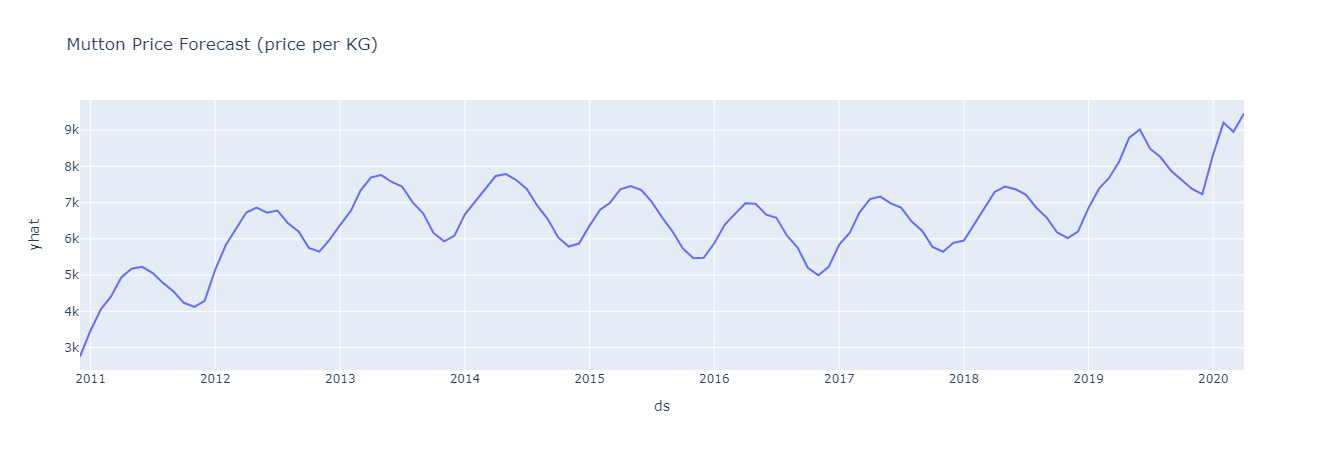

In [96]:
px.line(m_forecast, x='ds', y='yhat', title='Mutton Price Forecast (price per KG)')

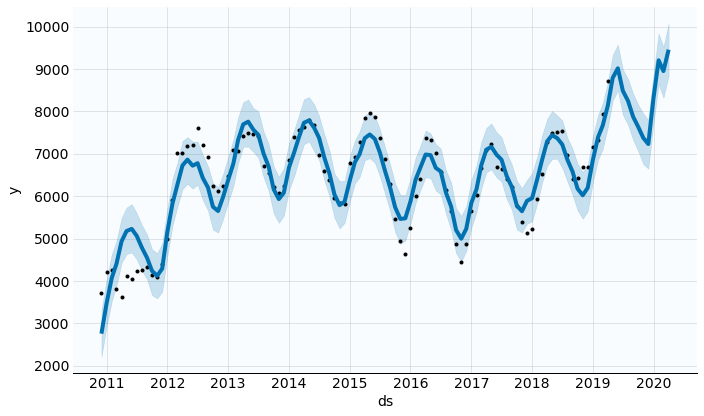

In [97]:
mutton_forecast = m.plot(m_forecast)

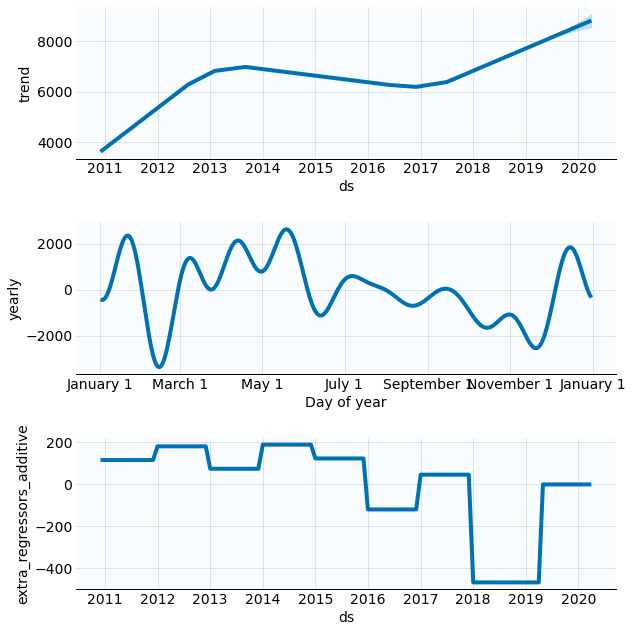

In [98]:
mutton_components = m.plot_components(m_forecast)

#### Forecasts to publish

Our time series analysis is yielding quite good results. Based on our current data we don't have any other significant regressors to deal with. As such

In [99]:
b_forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'animal_loss', 'animal_loss_lower', 'animal_loss_upper',
       'extra_regressors_additive', 'extra_regressors_additive_lower',
       'extra_regressors_additive_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')

- Trend and forecast
- Animal loss
- CPI

In [100]:
b_forecast.head()

ds        trend   yhat_lower   yhat_upper  trend_lower  trend_upper  \
0 2010-12-01  4616.620051  3199.019422  4526.519638  4616.620051  4616.620051   
1 2011-01-01  4790.769430  3874.605279  5222.495520  4790.769430  4790.769430   
2 2011-02-01  4964.918809  4436.213966  5729.843629  4964.918809  4964.918809   
3 2011-03-01  5122.215022  4841.483374  6171.345232  5122.215022  5122.215022   
4 2011-04-01  5296.364401  5323.777149  6633.141876  5296.364401  5296.364401   

   additive_terms  additive_terms_lower  additive_terms_upper  animal_loss  \
0     -777.094478           -777.094478           -777.094478   100.727138   
1     -250.970514           -250.970514           -250.970514   100.727138   
2      131.370457            131.370457            131.370457   100.727138   
3      384.426749            384.426749            384.426749   100.727138   
4      707.176929            707.176929            707.176929   100.727138   

   ...  extra_regressors_additive  extra_regressors_additive_lower  \
0  ...                 100.727138                       100.727138   
1  ...                 100.727138                       100.727138   
2  ...                 100.727138                       100.727138   
3  ...                 100.727138                       100.727138   
4  ...                 100.727138                       100.727138   

   extra_regressors_additive_upper      yearly  yearly_lower  yearly_upper  \
0                       100.727138 -877.821616   -877.821616   -877.821616   
1                       100.727138 -351.697651   -351.697651   -351.697651   
2                       100.727138   30.643319     30.643319     30.643319   
3                       100.727138  283.699611    283.699611    283.699611   
4                       100.727138  606.449792    606.449792    606.449792   

   multiplicative_terms  multiplicative_terms_lower  \
0                   0.0                         0.0   
1                   0.0                         0.0   
2                   0.0                         0.0   
3                   0.0                         0.0   
4                   0.0                         0.0   

   multiplicative_terms_upper         yhat  
0                         0.0  3839.525573  
1                         0.0  4539.798916  
2                         0.0  5096.289265  
3                         0.0  5506.641771  
4                         0.0  6003.541330  

[5 rows x 22 columns]

In [101]:
df.head()

date  Beef, without bones, kg  Mutton, with bones, kg  \
0 2010-12-01                     4640                    3710   
1 2011-01-01                     5380                    4205   
2 2011-02-01                     5415                    4250   
3 2011-03-01                     5070                    3810   
4 2011-04-01                     4845                    3610   

   Goat meat, with bones, kg  Chicken, thigh, kg, imported  \
0                     2590.0                        4420.0   
1                     3165.0                        4285.0   
2                     3395.0                        4195.0   
3                     3260.0                        4090.0   
4                     2805.0                        3910.0   

   Horse meat, with bones, kg  Frozen beef   (t)  Horse meat (t)  \
0                      2710.0                NaN             NaN   
1                      3460.0                NaN          3865.1   
2                      3605.0                NaN             NaN   
3                      3535.0                NaN             NaN   
4                      3290.0                NaN             NaN   

   Edible meet offal (t)  animal_loss  Monthly CPI  avg_salary  livestock  \
0                    NaN          NaN          2.4         NaN        NaN   
1                  414.6        651.3          3.1       430.3   36335.78   
2                    NaN          NaN          0.3       430.3        NaN   
3                    NaN          NaN         -1.3       430.3        NaN   
4                    NaN          NaN         -0.5       462.1        NaN   

   animal_product_export  Beef without bones adj  Mutton adj  \
0                    NaN                     NaN         NaN   
1                39946.9                  5380.0      4205.0   
2                    NaN                  5396.0      4218.0   
3                    NaN                  5326.0      4163.0   
4                    NaN                  5299.0      4142.0   

   beef_salary_percent  mutton_salary_percent  
0                  NaN                    NaN  
1            28.131536              21.987567  
2            28.314548              22.222868  
3            26.510574              19.922147  
4            23.590673              17.577364

In [102]:
b_forecast.head()

ds        trend   yhat_lower   yhat_upper  trend_lower  trend_upper  \
0 2010-12-01  4616.620051  3199.019422  4526.519638  4616.620051  4616.620051   
1 2011-01-01  4790.769430  3874.605279  5222.495520  4790.769430  4790.769430   
2 2011-02-01  4964.918809  4436.213966  5729.843629  4964.918809  4964.918809   
3 2011-03-01  5122.215022  4841.483374  6171.345232  5122.215022  5122.215022   
4 2011-04-01  5296.364401  5323.777149  6633.141876  5296.364401  5296.364401   

   additive_terms  additive_terms_lower  additive_terms_upper  animal_loss  \
0     -777.094478           -777.094478           -777.094478   100.727138   
1     -250.970514           -250.970514           -250.970514   100.727138   
2      131.370457            131.370457            131.370457   100.727138   
3      384.426749            384.426749            384.426749   100.727138   
4      707.176929            707.176929            707.176929   100.727138   

   ...  extra_regressors_additive  extra_regressors_additive_lower  \
0  ...                 100.727138                       100.727138   
1  ...                 100.727138                       100.727138   
2  ...                 100.727138                       100.727138   
3  ...                 100.727138                       100.727138   
4  ...                 100.727138                       100.727138   

   extra_regressors_additive_upper      yearly  yearly_lower  yearly_upper  \
0                       100.727138 -877.821616   -877.821616   -877.821616   
1                       100.727138 -351.697651   -351.697651   -351.697651   
2                       100.727138   30.643319     30.643319     30.643319   
3                       100.727138  283.699611    283.699611    283.699611   
4                       100.727138  606.449792    606.449792    606.449792   

   multiplicative_terms  multiplicative_terms_lower  \
0                   0.0                         0.0   
1                   0.0                         0.0   
2                   0.0                         0.0   
3                   0.0                         0.0   
4                   0.0                         0.0   

   multiplicative_terms_upper         yhat  
0                         0.0  3839.525573  
1                         0.0  4539.798916  
2                         0.0  5096.289265  
3                         0.0  5506.641771  
4                         0.0  6003.541330  

[5 rows x 22 columns]

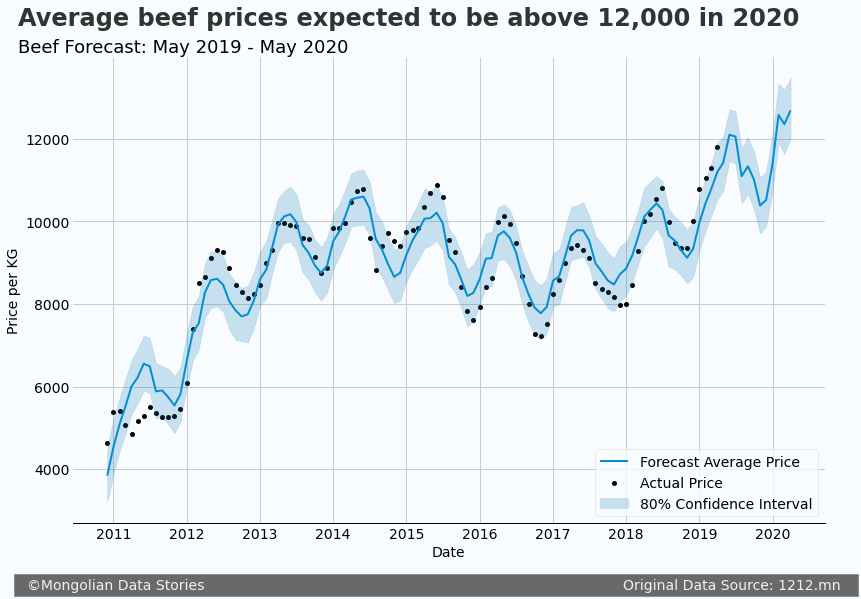

In [107]:
fig, ax = plt.subplots()
ax.plot(b_forecast['ds'], b_forecast['yhat'],linewidth=2)
ax.scatter(m.history['ds'].dt.to_pydatetime(), b.history['y'],c='black',marker='.',linewidths=2)
ax.fill_between(b_forecast['ds'], b_forecast['yhat_lower'], b_forecast['yhat_upper'], color='#0072B2', alpha=0.2)

#ax.set_xlim(left='2010-11', right='2020-5')
ax.legend(['Forecast Average Price','Actual Price','80% Confidence Interval'],loc=4)

ax.set_xlabel('Date')
ax.set_ylabel('Price per KG')
ax.text(x = 14500, y = 14750, s = 'Average beef prices expected to be above 12,000 in 2020', fontsize=24, weight='bold', alpha=.8)
ax.text(x = 14500, y = 14100, s= 'Beef Forecast: May 2019 - May 2020', fontsize=18)
ax.text(x = 14500, y = 1100, s = '  ©Mongolian Data Stories                                                                                             Original Data Source: 1212.mn   ', fontsize = 14, color = '#f0f0f0', backgroundcolor = 'dimgrey')
plt.savefig('Images/beef-forecast.png', dpi = 300, bbox_inches="tight")

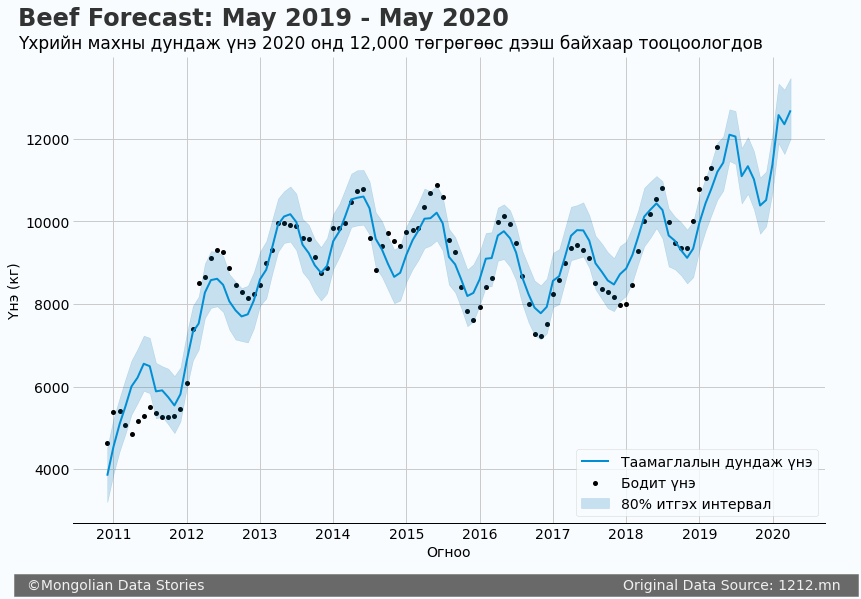

In [108]:
fig, ax = plt.subplots()
ax.plot(b_forecast['ds'], b_forecast['yhat'],linewidth=2)
ax.scatter(m.history['ds'].dt.to_pydatetime(), b.history['y'],c='black',marker='.',linewidths=2)
ax.fill_between(b_forecast['ds'], b_forecast['yhat_lower'], b_forecast['yhat_upper'], color='#0072B2', alpha=0.2)

#ax.set_xlim(left='2010.11', right='2020.5')
ax.legend(['Таамаглалын дундаж үнэ','Бодит үнэ','80% итгэх интервал'],loc=4)

ax.set_xlabel('Огноо')
ax.set_ylabel('Үнэ (кг)')
ax.text(x = 14500, y = 14750, s = 'Beef Forecast: May 2019 - May 2020', fontsize=24, weight='bold', alpha=.8)
ax.text(x = 14500, y = 14200, s= 'Үхрийн махны дундаж үнэ 2020 онд 12,000 төгрөгөөс дээш байхаар тооцоологдов', fontsize=17)
ax.text(x = 14500, y = 1100, s = '  ©Mongolian Data Stories                                                                                             Original Data Source: 1212.mn   ', fontsize = 14, color = '#f0f0f0', backgroundcolor = 'dimgrey')
plt.savefig('Images/beef-forecast-mng.png', dpi = 300, bbox_inches="tight")

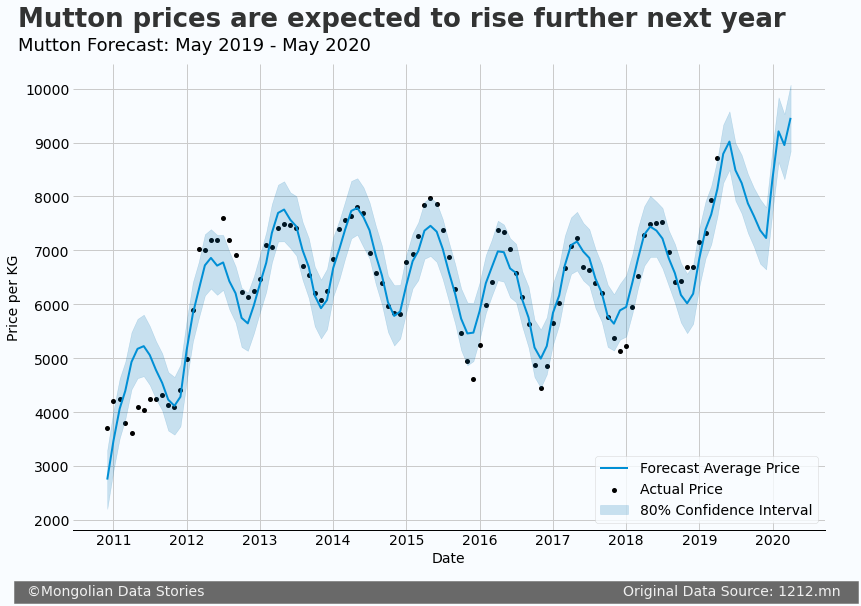

In [111]:
fig, ax = plt.subplots()
ax.plot(m_forecast['ds'], m_forecast['yhat'],linewidth=2)
ax.scatter(m.history['ds'].dt.to_pydatetime(), m.history['y'],c='black',marker='.',linewidths=2)
ax.fill_between(m_forecast['ds'], m_forecast['yhat_lower'], m_forecast['yhat_upper'], color='#0072B2', alpha=0.2)

#ax.set_xlim(left='2010.11', right='2020.5')
ax.legend(['Forecast Average Price','Actual Price','80% Confidence Interval'],loc=4)

ax.set_xlabel('Date')
ax.set_ylabel('Price per KG')
ax.text(x = 14500, y = 11150, s = 'Mutton prices are expected to rise further next year', fontsize=26, weight='bold', alpha=.8)
ax.text(x = 14500, y = 10700, s= 'Mutton Forecast: May 2019 - May 2020', fontsize=18)
ax.text(x = 14500, y = 600, s = '  ©Mongolian Data Stories                                                                                             Original Data Source: 1212.mn   ', fontsize = 14, color = '#f0f0f0', backgroundcolor = 'dimgrey')
plt.savefig('Images/mutton-forecast.png', dpi = 300, bbox_inches="tight")

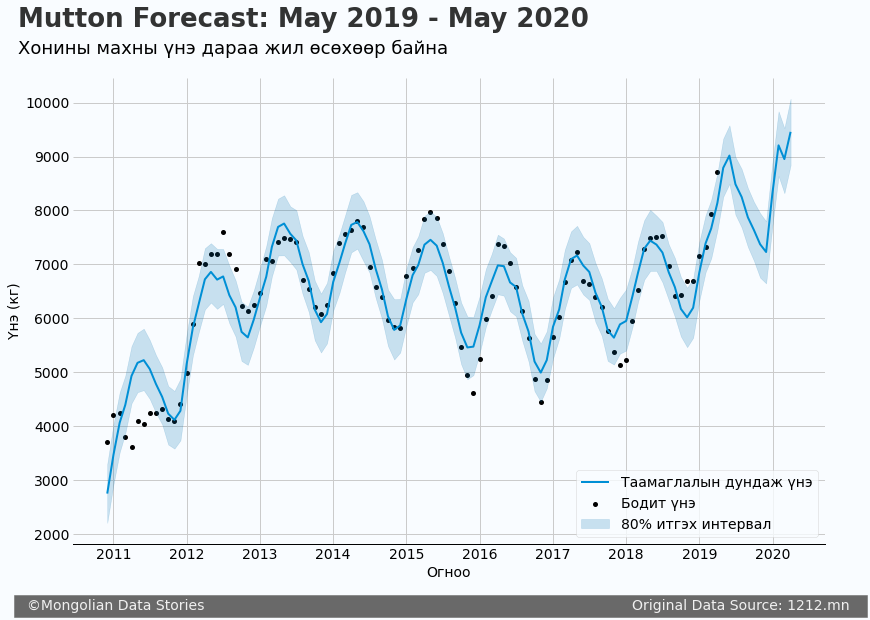

In [112]:
fig, ax = plt.subplots()
ax.plot(m_forecast['ds'], m_forecast['yhat'],linewidth=2)
ax.scatter(m.history['ds'].dt.to_pydatetime(), m.history['y'],c='black',marker='.',linewidths=2)
ax.fill_between(m_forecast['ds'], m_forecast['yhat_lower'], m_forecast['yhat_upper'], color='#0072B2', alpha=0.2)

#ax.set_xlim(left='2010.11', right='2020.5')
ax.legend(['Таамаглалын дундаж үнэ','Бодит үнэ','80% итгэх интервал'],loc=4)

ax.set_xlabel('Огноо')
ax.set_ylabel('Үнэ (кг)')
ax.text(x = 14500, y = 11400, s = 'Mutton Forecast: May 2019 - May 2020', fontsize=26, weight='bold', alpha=.8)
ax.text(x = 14500, y = 10900, s= 'Хонины махны үнэ дараа жил өсөхөөр байна', fontsize=18)
ax.text(x = 14500, y = 600, s = '  ©Mongolian Data Stories                                                                                               Original Data Source: 1212.mn   ', fontsize = 14, color = '#f0f0f0', backgroundcolor = 'dimgrey')
plt.savefig('Images/mutton-forecast-mng.png', dpi = 300, bbox_inches="tight")

In [123]:
b_forecast.to_csv('Data/intermediate/2019_forecast.csv')

## Check USD

A commentor asked to see USD-MNT Exchange rate overlayed on the meat price. 

In [117]:
usd = pd.read_csv('G:/My Drive/Data Science/Mongolian Data Stories/Github Repository/MNT Exchange Rate Forecast/Part 2 - Machine Learning Model/Data/Raw Data/USD-MNT.csv')

In [118]:
usd['date'] = pd.to_datetime(usd['Date'])

In [119]:
usd = pd.merge(usd,df[['date','Beef, without bones, kg','Mutton, with bones, kg']],how='inner')

In [120]:
usd.tail()

Date      USD       date  Beef, without bones, kg  \
90   7/1/2018  2462.82 2018-07-01                    10814   
91   8/1/2018  2462.51 2018-08-01                     9981   
92   9/1/2018  2472.99 2018-09-01                     9480   
93  10/1/2018  2550.04 2018-10-01                     9360   
94  11/1/2018  2564.89 2018-11-01                     9349   

    Mutton, with bones, kg  
90                    7533  
91                    6977  
92                    6412  
93                    6437  
94                    6689

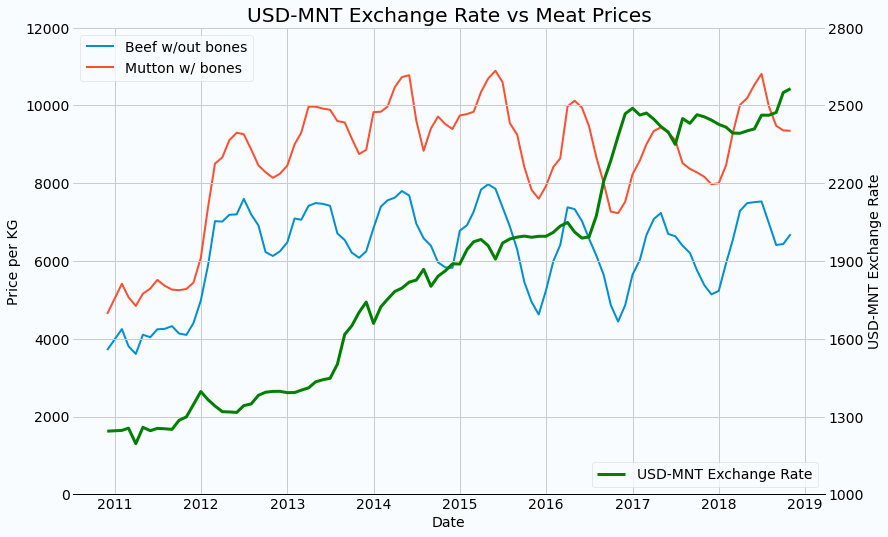

In [121]:
fig, ax = plt.subplots()
ax.plot(usd['date'], usd['Mutton, with bones, kg'] , linewidth=2)
ax.plot(usd['date'], usd['Beef, without bones, kg'] , linewidth=2)
ax2 = ax.twinx()
ax2.plot(usd['date'], usd['USD'], linewidth=3, color='g')
ax.set_xlabel('Date')
ax.set_ylabel('Price per KG')
ax2.set_ylabel('USD-MNT Exchange Rate')
ax.legend(['Beef w/out bones','Mutton w/ bones'],loc=2)
ax2.legend(['USD-MNT Exchange Rate'],loc=4)
ax.set_ylim(0,12000)
ax2.set_yticks(np.linspace(ax2.get_yticks()[0], ax2.get_yticks()[-1], len(ax.get_yticks())))
ax.set_title('USD-MNT Exchange Rate vs Meat Prices')

#ax.text(x = 733650, y = 13150, s = 'Animal losses are a large driver of price fluctuations', fontsize=24, weight='bold', alpha=.8)
#ax.text(x = 733650, y = 12500, s= 'High animal loss correlates with high price variations', fontsize=18)
#ax.text(x = 733600, y = -1700, s = '  ©Mongolian Data Stories                                                                                                        Original Data Source: 1212.mn   ', fontsize = 14, color = '#f0f0f0', backgroundcolor = 'dimgrey')
plt.savefig('Images/usd-overlay.png', dpi = 300, bbox_inches="tight")

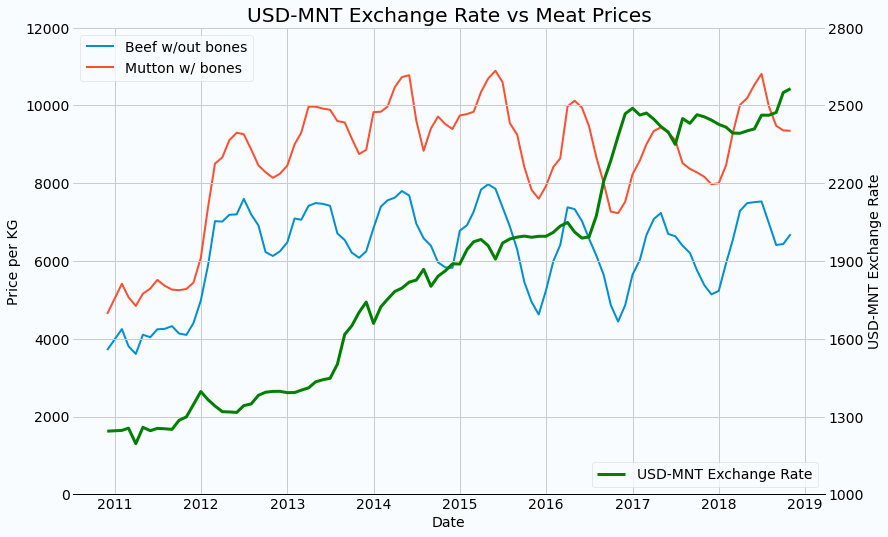

In [122]:
fig, ax = plt.subplots()
ax.plot(usd['date'], usd['Mutton, with bones, kg'] , linewidth=2)
ax.plot(usd['date'], usd['Beef, without bones, kg'] , linewidth=2)
ax2 = ax.twinx()
ax2.plot(usd['date'], usd['USD'], linewidth=3, color='g')
ax.set_xlabel('Date')
ax.set_ylabel('Price per KG')
ax2.set_ylabel('USD-MNT Exchange Rate')
ax.legend(['Beef w/out bones','Mutton w/ bones'],loc=2)
ax2.legend(['USD-MNT Exchange Rate'],loc=4)
ax.set_ylim(0,12000)
ax2.set_yticks(np.linspace(ax2.get_yticks()[0], ax2.get_yticks()[-1], len(ax.get_yticks())))
ax.set_title('USD-MNT Exchange Rate vs Meat Prices')

#ax.text(x = 733650, y = 13150, s = 'Animal losses are a large driver of price fluctuations', fontsize=24, weight='bold', alpha=.8)
#ax.text(x = 733650, y = 12500, s= 'High animal loss correlates with high price variations', fontsize=18)
#ax.text(x = 733600, y = -1700, s = '  ©Mongolian Data Stories                                                                                                        Original Data Source: 1212.mn   ', fontsize = 14, color = '#f0f0f0', backgroundcolor = 'dimgrey')
plt.savefig('Images/usd-overlay.png', dpi = 300, bbox_inches="tight")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=defae11f-5e35-45f1-9c6e-497c7dbadc1f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>